Вариационная модель звезды

Как параметр задана масса звезды M.
Звезда разбита на N сферических слоев.
Также задано распределение водорода по слоям.
Имеется N+1 точка - расстояния от центра до i-го слоя.
Неизвестными являются массивы расстояний r[i] и температур t[i]

Date of creation: 2.07.2020

Last updated: 3.07.2020

In [26]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [27]:
import physics as ph

In [28]:
from Sun import SSM18 as s

In [29]:
pi = math.pi
# K = 6 # number of interpolated layers
# dimM = 17*K+1 # N+1 - число точек модели (сферических слоев + 1)
# Z = s.Z

In [30]:
# df1 = s.load_interpolated_data(K)
def load_model(epoch):
    filename = 'FromCenter/1epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 0
df1 = load_model(epoch)
dimM = len(df1.index)
df1

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.333000e+07,94.554471,0.000000e+00,0.732,1.318613,0.0,1.730205e+17,8.561869e-11
1,1,1.335360e+26,6.960000e+07,1.333000e+07,94.554471,1.634396e+27,0.732,1.318613,1.0,1.730205e+17,8.561869e-11
2,2,1.735967e+26,7.656000e+07,1.332997e+07,94.554040,2.124711e+27,0.732,1.318620,0.0,1.730193e+17,8.561741e-11
3,3,2.220700e+26,8.352000e+07,1.332993e+07,94.553578,2.717979e+27,0.732,1.318627,0.0,1.730180e+17,8.561603e-11
4,4,2.797568e+26,9.048000e+07,1.332990e+07,94.553080,3.424001e+27,0.732,1.318634,0.0,1.730166e+17,8.561455e-11
...,...,...,...,...,...,...,...,...,...,...,...
13995,13995,1.989737e+33,6.262796e+10,5.465099e+03,0.000031,2.461129e+33,0.732,0.003113,0.0,2.349260e+07,4.899800e-49
13996,13996,1.989737e+33,6.262800e+10,5.460450e+03,0.000031,2.461129e+33,0.732,0.003109,0.0,2.344258e+07,4.849587e-49
13997,13997,1.989737e+33,6.262805e+10,5.455801e+03,0.000031,2.461129e+33,0.732,0.003105,0.0,2.339263e+07,4.799847e-49
13998,13998,1.989737e+33,6.262810e+10,5.451153e+03,0.000031,2.461129e+33,0.732,0.003101,0.0,2.334274e+07,4.750576e-49


In [120]:
x = df1['Hydrogen'].values
r = df1['Radius'].values
m = df1['Mass'].values
t = df1['Temperature'].values
# The rest may be computed from the above variables.
d = df1['Density'].values
l = df1['Luminosity'].values
p = df1['Pressure'].values
k = df1['Opacity'].values
c = df1['Convection'].values

In [92]:
# t = t*(1. + 0.01*np.cos(r/s.R*ph.pi/2))

In [32]:
d1 = np.zeros(dimM)
l1 = np.zeros(dimM)
p1 = np.zeros(dimM)
k1 = np.zeros(dimM)

In [33]:

# d[0] = 3*m[1]/4/pi/pow(r[1], 3)
# d[1] = 0.5*d[0] + 0.5*(m[2] - m[1])/4/pi/pow((r[1] + r[2])/2, 2)/(r[2] - r[1])
# for i in range(2, dimM-1):
#     d[i] = ((m[i+1] - m[i])/pow(r[i], 2)/(r[i+1] - r[i]) + (m[i] - m[i-1])/pow(r[i], 2)/(r[i] - r[i-1]))/8/pi
# d[dimM-1] = 0.
# for i in range(dimM):
#     p[i] = ph.Pressure(d[i], t[i], x[i], 1 - Z - x[i], Z)
#     k[i] = ph.opacity(d[i], t[i], x[i], 1 - Z - x[i], Z)
# l[0] = 0.
# for i in range(1, dimM):
#     l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(d[i], t[i], x[i], 1 - Z - x[i], Z) # /0.5879669006862714

In [99]:
e = np.zeros(dimM) # энерговыделения
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

Уравнение массы

In [37]:
for i in range(1, dimM-1, 70):
    d1[i] = 3/4/pi*(m[i+1] - m[i-1])/(pow(r[i+1], 3) - pow(r[i-1], 3))
    print(i, d[i], d1[i], pow((d1[i] - d[i])/d[i], 2))

1 94.55447133 92.35217738724285 0.0005424833672384153
71 94.424243307852 93.24642913056148 0.00015559173685700028
141 94.08436766953078 93.45781310929694 4.4348899725577234e-05
211 93.5363327905664 93.11146115492683 2.063263994913024e-05
281 92.78333409600175 92.46354549795963 1.1879167365063856e-05
351 91.8296529629725 91.5746585437576 7.710729449942377e-06
421 90.680506322598 90.46967323977614 5.4056714394244745e-06
491 89.34189393662619 89.16324021165687 3.998654142032694e-06
561 87.8204511507608 87.66639627815213 3.077227116074456e-06
631 86.12332387865843 85.98876289464103 2.4411627991177734e-06
701 84.2580837480123 84.1394105953393 1.983726542123654e-06
771 82.2327005442298 82.12726961298064 1.6437924426694486e-06
841 80.0674460132323 79.97324323360408 1.3842530339084234e-06
911 77.79279844336978 77.70823340749875 1.181688163851116e-06
981 75.42078110074982 75.34458936613179 1.0205485507076945e-06
1051 72.95959244251496 72.89075246318808 8.902595964806917e-07
1121 70.416804081912

Условие гидростатики

In [113]:
for i in range(1, dimM-1):
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    a[i] = -ph.G*m[i]*d[i]/pow(r[i], 2)
    da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1]) #- a[i]
    print(i, a[i], da[i], pow((a[i] - da[i])/a[i], 2))

1 -173855.2558078713 -86927.62790344827 0.2500000000028033
2 -186785.68916118264 -180320.4724850575 0.0011980611095930979
3 -200776.3866436656 -193781.03790344828 0.0012139295200779066
4 -215514.7534157475 -208145.57002988504 0.0011691889895513639
5 -230795.4846572337 -223155.1190367816 0.0010959069157977944
6 -246479.20591004207 -238637.34528275864 0.0010122264150082174
7 -262468.59075843834 -254473.89833333335 0.000927788192602947
8 -278693.9968139362 -270581.29378620686 0.000847375550887924
9 -295104.5183757738 -286899.2575954023 0.0007730953456286261
10 -311662.2407235205 -303383.37954942527 0.0007056231533462501
11 -328338.4503980361 -320000.3455609195 0.0006448982734956889
12 -345111.07573593897 -336724.7630689655 0.0005905059874023573
13 -361962.9214216771 -353536.99857931037 0.0005418845718432707
14 -378880.4274578885 -370421.67443908047 0.0004984347897596204
15 -395852.7817470536 -387366.6046022988 0.00045957541079883266
16 -412871.27561972704 -404362.0286827586 0.000424769099

300 -5165686.91133391 -5157863.430089655 2.2937386403514523e-06
301 -5181322.826502077 -5173504.868917242 2.2766974200694945e-06
302 -5196947.662289157 -5189135.244395402 2.2598220706261252e-06
303 -5212561.386670238 -5204754.52448046 2.2431104624086203e-06
304 -5228163.9676574385 -5220362.677163219 2.2265605013517403e-06
305 -5243755.373299965 -5235959.670478161 2.210170123058065e-06
306 -5259335.571684208 -5251545.4724919535 2.1939372988105676e-06
307 -5274904.530933815 -5267120.051308046 2.177860032320672e-06
308 -5290462.219209779 -5282683.375071265 2.1619363566069806e-06
309 -5306008.6047105035 -5298235.411960919 2.146164337314033e-06
310 -5321543.655671898 -5313776.130193103 2.130542070865263e-06
311 -5337067.3403674485 -5329305.49802069 2.1150676839181978e-06
312 -5352579.627108303 -5344823.483737931 2.099739330351541e-06
313 -5368080.4842433445 -5360330.055675862 2.084555193292115e-06
314 -5383569.880159271 -5375825.182202298 2.0695134846114765e-06
315 -5399047.7832806865 -5391

528 -8385955.901213286 -8379766.657843678 5.447157988110086e-07
529 -8398317.12412072 -8392136.512666667 5.415996129089729e-07
530 -8410661.061282635 -8404489.09270115 5.385017879284926e-07
531 -8422987.690835949 -8416824.37605977 5.354221893863619e-07
532 -8435296.990967965 -8429142.340903448 5.323606844089606e-07
533 -8447588.93991644 -8441442.965443678 5.293171413267535e-07
534 -8459863.515969606 -8453726.22794253 5.26291429665405e-07
535 -8472120.697466198 -8465992.10671724 5.232834193522493e-07
536 -8484360.462795503 -8478240.580131035 5.202929822898974e-07
537 -8496582.790397376 -8490471.626595402 5.173199919445171e-07
538 -8508787.658762299 -8502685.22457931 5.143643217800635e-07
539 -8520975.046431405 -8514881.352597702 5.114258472061115e-07
540 -8533144.931996517 -8527059.989213794 5.085044451701277e-07
541 -8545297.294100178 -8539221.113048276 5.055999926117061e-07
542 -8557432.111435685 -8551364.702767815 5.02712368383218e-07
543 -8569549.362747142 -8563490.737091955 4.99841

829 -11246487.363104064 -11243248.866293103 8.291882670957592e-08
830 -11252944.032554502 -11249715.697828736 8.230473056855139e-08
831 -11259380.378537035 -11256162.205545977 8.169392997363183e-08
832 -11265796.401797263 -11262588.390167816 8.108640969915205e-08
833 -11272192.103122255 -11268994.25245977 8.048215456227657e-08
834 -11278567.483340466 -11275379.793231035 7.988114936172687e-08
835 -11284922.543321675 -11281745.013331033 7.928337904824624e-08
836 -11291257.28397693 -11288089.913649425 7.868882872001851e-08
837 -11297571.706258485 -11294414.495117242 7.809748356122469e-08
838 -11303865.811159715 -11300718.758708045 7.750932878023726e-08
839 -11310139.599715091 -11307002.705436781 7.692434966570395e-08
840 -11316393.073000079 -11313266.33635747 7.63425316937593e-08
841 -11322626.232131097 -11319509.652565517 7.576386041119112e-08
842 -11328839.078265443 -11325732.655196551 7.518832148733838e-08
843 -11335031.612601234 -11331935.345433332 7.46159003776098e-08
844 -11341203.8

1116 -12281343.62178181 -12280930.101647127 1.1337088993167063e-09
1117 -12282151.933668474 -12281747.777726438 1.0828018916268212e-09
1118 -12282941.526635809 -12282546.730152873 1.0330986199584203e-09
1119 -12283712.410177525 -12283326.968406897 9.84596472015353e-10
1120 -12284464.593817439 -12284088.501997702 9.372928600755746e-10
1121 -12285198.087109478 -12284831.340464368 8.911852144427258e-10
1122 -12285912.899637712 -12285555.493373562 8.462709942730975e-10
1123 -12286609.04101639 -12286260.970326437 8.025476542323373e-10
1124 -12287286.52088994 -12286947.780951723 7.600126781051159e-10
1125 -12287945.348933015 -12287615.934911493 7.186635521608035e-10
1126 -12288585.534850508 -12288265.441893104 6.784978011743865e-10
1127 -12289207.088377565 -12288896.311612643 6.395129711948777e-10
1128 -12289810.019279642 -12289508.553828735 6.017065736021121e-10
1129 -12290394.337352494 -12290102.178317241 5.650761904264856e-10
1130 -12290960.052422237 -12290677.194887357 5.296194061502511e

1402 -11828538.52679179 -11830392.207257472 2.4558824132351845e-08
1403 -11824818.402684111 -11826678.464737931 2.474377206149806e-08
1404 -11821085.532898681 -11822951.967791954 2.492935089873181e-08
1405 -11817339.934929669 -11819212.733913794 2.5115560412494878e-08
1406 -11813581.626268974 -11815460.78059885 2.5302400469513303e-08
1407 -11809810.624406328 -11811696.125337932 2.5489870878742116e-08
1408 -11806026.946829362 -11807918.78561839 2.5677971419211863e-08
1409 -11802230.611023664 -11804128.778926436 2.5866701900451967e-08
1410 -11798421.634472877 -11800326.122748276 2.605606219185572e-08
1411 -11794600.03465875 -11796510.834566668 2.6246052127164453e-08
1412 -11790765.829061214 -11792682.93186092 2.6436671502010155e-08
1413 -11786919.035158468 -11788842.432110345 2.66279201657987e-08
1414 -11783059.670427058 -11784989.352793105 2.6819797988718107e-08
1415 -11779187.75234191 -11781123.711385058 2.7012304828628488e-08
1416 -11775303.298376469 -11777245.52535977 2.7205440527175

1678 -10385148.836025335 -10388374.374396551 9.64670449711898e-08
1679 -10378690.867674207 -10381919.851849426 9.679360834198621e-08
1680 -10372226.025227427 -10375458.44645115 9.712073380651344e-08
1681 -10365754.326197153 -10368990.175712643 9.744842168460854e-08
1682 -10359275.788095193 -10362515.057146551 9.777667242167651e-08
1683 -10352790.428433096 -10356033.108264368 9.810548641068971e-08
1684 -10346298.26472229 -10349544.346577585 9.843486405266761e-08
1685 -10339799.314474137 -10343048.789597701 9.876480575402717e-08
1686 -10333293.595200036 -10336546.454836782 9.909531195465031e-08
1687 -10326781.124411542 -10330037.359805748 9.942638301597206e-08
1688 -10320261.919620432 -10323521.522016091 9.975801932163398e-08
1689 -10313735.998338813 -10316998.958979886 1.0009022127131687e-07
1690 -10307203.378079206 -10310469.688209195 1.0042298923943938e-07
1691 -10300664.076354671 -10303933.727217242 1.007563236393583e-07
1692 -10294118.11067884 -10297391.09351724 1.010902248493489e-0

1939 -8542587.704893101 -8546283.181776436 1.87138044618936e-07
1940 -8535195.57091912 -8538891.63790632 1.8752221056581202e-07
1941 -8527802.26930701 -8531498.920113217 1.87906849978975e-07
1942 -8520407.812619952 -8524105.040963218 1.882919632093813e-07
1943 -8513012.213415436 -8516710.01301724 1.8867755066029802e-07
1944 -8505615.484245282 -8509313.848829884 1.8906361266743475e-07
1945 -8498217.637655767 -8501916.560950574 1.894501496032327e-07
1946 -8490818.686187712 -8494518.161922414 1.8983716175046493e-07
1947 -8483418.642376564 -8487118.664282184 1.902246492925685e-07
1948 -8476017.518752495 -8479718.080564369 1.9061261271738657e-07
1949 -8468615.327840475 -8472316.423296552 1.910010523373095e-07
1950 -8461212.08216037 -8464913.705000576 1.9138996839739015e-07
1951 -8453807.794227023 -8457509.938194253 1.9177936124374927e-07
1952 -8446402.476550346 -8450105.135389082 1.9216923107743374e-07
1953 -8438996.141635414 -8442699.309093103 1.925595782406946e-07
1954 -8431588.801982526 

2246 -6306905.990075539 -6310365.084006323 3.008098102052814e-07
2247 -6299990.9745383505 -6303448.482306897 3.011941098909849e-07
2248 -6293079.135750836 -6296535.055144828 3.015788096817215e-07
2249 -6286170.478135619 -6289624.806943104 3.019639094394521e-07
2250 -6279265.006114183 -6282717.742125 3.0234940927232456e-07
2251 -6272362.724106894 -6275813.865110632 3.027353089270409e-07
2252 -6265463.636533082 -6268913.180320115 3.031216083271508e-07
2253 -6258567.747811068 -6262015.692172127 3.0350830731750744e-07
2254 -6251675.062358236 -6255121.40508477 3.03895405801386e-07
2255 -6244785.584591071 -6248230.323474426 3.042829035331941e-07
2256 -6237899.318925214 -6241342.451757759 3.0467080046181346e-07
2257 -6231016.269775515 -6234457.794350287 3.050590964689567e-07
2258 -6224136.441556074 -6227576.355665805 3.054477912597552e-07
2259 -6217259.838680306 -6220698.14011839 3.0583688470534373e-07
2260 -6210386.465560969 -6213823.15212069 3.0622637653544605e-07
2261 -6203516.326610233 -6

2514 -4599493.076482099 -4602359.901889656 3.884924209960063e-07
2515 -4593764.227697114 -4596628.652089942 3.888099083146091e-07
2516 -4588040.178962318 -4590902.20332931 3.891277733429035e-07
2517 -4582320.928303654 -4585180.553632472 3.8944601631541997e-07
2518 -4576606.473753605 -4579463.701028736 3.897646369343068e-07
2519 -4570896.813351185 -4573751.643552012 3.9008363436771485e-07
2520 -4565191.945141988 -4568044.379246552 3.904030088053083e-07
2521 -4559491.867178187 -4562341.906160345 3.9072275965449457e-07
2522 -4553796.577518556 -4556644.222348276 3.9104288639488403e-07
2523 -4548106.074228495 -4550951.325873563 3.913633889701282e-07
2524 -4542420.35538004 -4545263.21480431 3.916842668360899e-07
2525 -4536739.419051884 -4539579.887215804 3.920055195860689e-07
2526 -4531063.263329393 -4533901.341190517 3.9232714694886705e-07
2527 -4525391.886304627 -4528227.574816953 3.926491484646932e-07
2528 -4519725.286076349 -4522558.586190517 3.929715237205022e-07
2529 -4514063.460750044

2777 -3264386.0844398024 -3266570.1974556036 4.476588535981434e-07
2778 -3260023.0872823233 -3262204.5858610636 4.4778394409854727e-07
2779 -3255665.3114811582 -3257844.1993816094 4.4790949609181654e-07
2780 -3251312.7495339843 -3253489.0305074714 4.480355099467317e-07
2781 -3246965.393953821 -3249139.0717438217 4.48161985861325e-07
2782 -3242623.2372690174 -3244794.3156113504 4.482889241048809e-07
2783 -3238286.2720232466 -3240454.7546461206 4.4841632496049915e-07
2784 -3233954.4907754837 -3236120.3813994257 4.485441886756366e-07
2785 -3229627.886100006 -3231791.1884377874 4.486725154606843e-07
2786 -3225306.4505863725 -3227467.168343247 4.4880130561811426e-07
2787 -3220990.1768394145 -3223148.3137129312 4.489305593670655e-07
2788 -3216679.057479227 -3218834.617159339 4.490602769649601e-07
2789 -3212373.0851411493 -3214526.071310201 4.4919045865766384e-07
2790 -3208072.2524757646 -3210222.668808477 4.493211046786231e-07
2791 -3203776.5521488744 -3205924.402312356 4.494522152594996e-07

3109 -2064563.9344256602 -2066043.9750755746 5.13914195866813e-07
3110 -2061607.333295346 -2063085.6338604884 5.141781118492003e-07
3111 -2058654.2089728895 -2060130.7711341954 5.144422875724712e-07
3112 -2055704.5581053982 -2057179.383539224 5.147067211540901e-07
3113 -2052758.3773488193 -2054231.467727155 5.149714108418493e-07
3114 -2049815.6633679096 -2051287.0203583334 5.152363548345208e-07
3115 -2046876.4128362162 -2048346.0381020114 5.15501551395177e-07
3116 -2043940.6224360408 -2045408.517636063 5.157669986760715e-07
3117 -2041008.2888584149 -2042474.4556471263 5.16032694835922e-07
3118 -2038079.4088030732 -2039543.8488307472 5.16298638159705e-07
3119 -2035153.9789784239 -2036616.6938908047 5.165648266751337e-07
3120 -2032231.9961015242 -2033692.9875399424 5.168312584727422e-07
3121 -2029313.456898046 -2030772.7264997126 5.170979318333738e-07
3122 -2026398.3581022543 -2027855.9075001436 5.173648449376223e-07
3123 -2023486.696456972 -2024942.5272795977 5.176319957893746e-07
3124 

3389 -1368804.8370287952 -1369807.6860885057 5.36769809211224e-07
3390 -1366802.2597096625 -1367803.5483691809 5.366698761605573e-07
3391 -1364802.7968692754 -1365802.5282894396 5.365706032210408e-07
3392 -1362806.442202384 -1363804.6195358476 5.364719899235083e-07
3393 -1360813.1894200805 -1361809.8158112788 5.36374035738169e-07
3394 -1358823.032249757 -1359818.1108349138 5.362767401186774e-07
3395 -1356835.964435059 -1357829.498342385 5.361801027081564e-07
3396 -1354851.9797358464 -1355843.9720854168 5.360841229940432e-07
3397 -1352871.0719281489 -1353861.5258319685 5.35988800510193e-07
3398 -1350893.2348041218 -1351882.1533661638 5.358941348084981e-07
3399 -1348918.4621720044 -1349905.8484880747 5.358001252700656e-07
3400 -1346946.7478560782 -1347932.6050140085 5.357067714611412e-07
3401 -1344978.0856966204 -1345962.416776293 5.356140729515107e-07
3402 -1343012.4695498673 -1343995.277623204 5.355220292752549e-07
3403 -1341049.8932879637 -1342031.1814188939 5.354306399077086e-07
3404

3651 -934680.6261866201 -935362.1304297054 5.316314276524044e-07
3652 -933319.5323534694 -934000.0792700432 5.316862531766107e-07
3653 -931960.3499436554 -932639.9411485633 5.317415875598157e-07
3654 -930603.0757358113 -931281.712839727 5.317974299009359e-07
3655 -929247.7065167468 -929925.3911262213 5.318537793552402e-07
3656 -927894.2390814234 -928570.9727990661 5.319106353441878e-07
3657 -926542.6702329365 -927218.454657184 5.3196799690629e-07
3658 -925192.9967824937 -925867.8335076509 5.320258631252538e-07
3659 -923845.2155493922 -924519.1061659125 5.32084233506507e-07
3660 -922499.3233610009 -923172.2694552443 5.321431071559727e-07
3661 -921155.3170527392 -921827.3202068607 5.32202482982502e-07
3662 -919813.1934680552 -920484.2552603807 5.322623604707662e-07
3663 -918472.9494584055 -919143.0714632184 5.323227387485181e-07
3664 -917134.5818832363 -917803.7656708334 5.323836170125572e-07
3665 -915798.087609961 -916466.3347466595 5.324449944519456e-07
3666 -914463.4635139419 -915130.

3943 -607325.5657180727 -607782.0383536639 5.649192433751971e-07
3944 -606413.8666534554 -606869.71618574 5.650732905411148e-07
3945 -605503.4122284173 -605958.6394409842 5.652274448633636e-07
3946 -604594.2008795206 -605048.8065539871 5.653817038339317e-07
3947 -603686.2310468499 -604140.2159631465 5.655360656323791e-07
3948 -602779.5011740032 -603232.8661104166 5.65690528526118e-07
3949 -601874.0097080751 -602326.7554410201 5.658450901966866e-07
3950 -600969.7550996466 -601421.8824038793 5.659997488361758e-07
3951 -600066.7358027709 -600518.2454512212 5.661545022000405e-07
3952 -599164.9502749604 -599615.843038829 5.663093482659315e-07
3953 -598264.3969771737 -598714.6736260416 5.664642852672331e-07
3954 -597365.0743738029 -597814.735675467 5.666193110066471e-07
3955 -596466.9809326614 -596916.0276532328 5.667744235136382e-07
3956 -595570.1151249695 -596018.5480288435 5.669296207234699e-07
3957 -594674.4754253428 -595122.2952751797 5.670849005030335e-07
3958 -593780.0603117784 -59422

4222 -396557.9845358659 -396861.02899577946 5.839817840153452e-07
4223 -395953.0169748115 -396255.500755352 5.836021347421814e-07
4224 -395349.1680686173 -395651.09252171335 5.832233700966998e-07
4225 -394746.4351210759 -395047.80159486353 5.828454893404789e-07
4226 -394144.81544359756 -394445.6252823276 5.824684913317262e-07
4227 -393544.30635518965 -393844.56089935347 5.820923753704609e-07
4228 -392944.90518243733 -393244.60576882184 5.817171409258628e-07
4229 -392346.6092594824 -392645.757220977 5.813427866739062e-07
4230 -391749.41592800413 -392048.01259375 5.80969311825252e-07
4231 -391153.3225371988 -391451.36923261493 5.805967156469352e-07
4232 -390558.32644375914 -390855.8244904813 5.802249971247658e-07
4233 -389964.4250118553 -390261.3757278197 5.79854155526445e-07
4234 -389371.61561311415 -389668.0203124641 5.794841897110533e-07
4235 -388779.89562659856 -389075.7556198635 5.791150991927117e-07
4236 -388189.2624387889 -388484.5790327047 5.787468827392883e-07
4237 -387599.71344

4487 -268434.22618137056 -268626.1568338362 5.112259628686066e-07
4488 -268050.980711952 -268242.6034466595 5.110451448243006e-07
4489 -267668.34978615737 -267859.6652490661 5.108649450877846e-07
4490 -267286.33211554936 -267477.34095086204 5.106853626393002e-07
4491 -266904.92641513364 -267095.6292653376 5.105063966524596e-07
4492 -266524.1314033466 -266714.5289092313 5.103280463688614e-07
4493 -266143.9458020461 -266334.03860269394 5.101503109548789e-07
4494 -265764.3683365008 -265954.15706927085 5.099731894634176e-07
4495 -265385.39773537853 -265574.8830359375 5.097966810866716e-07
4496 -265007.03273073764 -265196.2152330639 5.096207850134448e-07
4497 -264629.27205801493 -264818.15239437856 5.094455002982785e-07
4498 -264252.11445601645 -264440.6932570043 5.092708261049637e-07
4499 -263875.5586669061 -264063.8365614583 5.090967617683802e-07
4500 -263499.60343619634 -263687.58105156245 5.089233063610148e-07
4501 -263124.2475127372 -263311.92547447915 5.087504589454308e-07
4502 -26274

4741 -187862.7093259364 -187993.29162519757 4.831560920061241e-07
4742 -187601.91985577438 -187732.31459086746 4.831094756576402e-07
4743 -187341.5048371459 -187471.71234647091 4.830633116178597e-07
4744 -187081.4635948595 -187211.48421600217 4.830175994153961e-07
4745 -186821.79545536172 -186951.62952511676 4.829723387355597e-07
4746 -186562.49974673364 -186692.1476010327 4.829275287118009e-07
4747 -186303.57579868563 -186433.03777271014 4.82883169301564e-07
4748 -186045.02294255325 -186174.29937063577 4.828392597111419e-07
4749 -185786.8405112927 -185915.93172691274 4.827957990979532e-07
4750 -185529.027839477 -185657.93417536817 4.827527874044926e-07
4751 -185271.58426329054 -185400.30605139188 4.82710224193684e-07
4752 -185014.5091205258 -185143.0466919181 4.826681085351018e-07
4753 -184757.80175057854 -184886.15543555137 4.826264399833197e-07
4754 -184501.4614944432 -184629.6316225126 4.82585218211059e-07
4755 -184245.48769470924 -184373.47459457617 4.825444425625484e-07
4756 -183

4969 -136936.72986180827 -137031.91645939296 4.83183062268295e-07
4970 -136746.6126742169 -136841.6712680047 4.832252464849952e-07
4971 -136556.7510999721 -136651.68188708695 4.832677478171441e-07
4972 -136367.14474574185 -136461.9479228538 4.833105655442749e-07
4973 -136177.7932191064 -136272.46898242636 4.833536988785381e-07
4974 -135988.69612855578 -136083.2446738326 4.833971469886567e-07
4975 -135799.85308348795 -135894.2746060255 4.834409092037939e-07
4976 -135611.26369420605 -135705.55838884698 4.834849846742099e-07
4977 -135422.92757191646 -135517.09563305497 4.835293726656027e-07
4978 -135234.8443287265 -135328.8859503143 4.835740724923286e-07
4979 -135047.01357764198 -135140.92895317887 4.836190833583266e-07
4980 -134859.4349325651 -134953.2242551006 4.836644044698222e-07
4981 -134672.1080082924 -134765.77147042926 4.83710035056721e-07
4982 -134485.03242051197 -134578.57021440374 4.837559743080941e-07
4983 -134298.20778580176 -134391.62010315194 4.838022213921159e-07
4984 -134

5234 -94452.14059925119 -94519.10662994791 5.026729382861248e-07
5235 -94318.38587225221 -94385.2632357534 5.027656147135342e-07
5236 -94184.80825967186 -94251.59706596175 5.028583278565523e-07
5237 -94051.40754197401 -94118.10790082166 5.029510764222794e-07
5238 -93918.18350005463 -93984.79552101294 5.030438590907118e-07
5239 -93785.13591524023 -93851.65970764188 5.031366744683552e-07
5240 -93652.26456928653 -93718.70024226382 5.032295214499139e-07
5241 -93519.56924437682 -93585.91690683369 5.033223984952334e-07
5242 -93387.04972312045 -93453.3094837509 5.034153043298764e-07
5243 -93254.70578855196 -93320.87775584141 5.035082376891773e-07
5244 -93122.5372241287 -93188.6215063353 5.036011970114134e-07
5245 -92990.54381373018 -93056.5405189296 5.036941814053837e-07
5246 -92858.72534165616 -92924.63457769845 5.037871893114306e-07
5247 -92727.08159262534 -92792.9034671426 5.03880219273306e-07
5248 -92595.61235177412 -92661.34697220277 5.039732701639178e-07
5249 -92464.31740465474 -92529.9

5492 -65795.86560604985 -65840.80622746049 4.6653146177298955e-07
5493 -65706.12394911343 -65750.99477758171 4.6635483003816e-07
5494 -65616.5215938694 -65661.32277148886 4.661787264824782e-07
5495 -65527.05825686515 -65571.78992536818 4.6600315048430544e-07
5496 -65437.73365538032 -65482.39595612428 4.6582810111212326e-07
5497 -65348.54750742443 -65393.14058140266 4.65653577642004e-07
5498 -65259.49953173469 -65304.023519580645 4.6547957941604524e-07
5499 -65170.58944777392 -65215.04448975396 4.6530610560414374e-07
5500 -65081.81697572822 -65126.20321175018 4.651331555348702e-07
5501 -64993.1818365048 -65037.4994061153 4.64960728459367e-07
5502 -64904.68375173 -64948.93279411817 4.6478882368637826e-07
5503 -64816.322443746874 -64860.50309774156 4.646174404449263e-07
5504 -64728.097635613085 -64772.21003968212 4.6444657792787486e-07
5505 -64640.00905109887 -64684.053343354884 4.642762354295239e-07
5506 -64552.056414684856 -64596.03273288883 4.6410641229820234e-07
5507 -64464.2394515598

5755 -46266.69816694134 -46297.26198191676 4.3639333566042236e-07
5756 -46205.65525021882 -46236.17670857803 4.3633524557485946e-07
5757 -46144.69689726049 -46175.17607373833 4.3627754615854686e-07
5758 -46083.82295895586 -46114.259928109284 4.3622023691110276e-07
5759 -46023.03328653878 -46053.42812274829 4.361633173605593e-07
5760 -45962.327731586534 -45992.68050906295 4.3610678721599446e-07
5761 -45901.706146018776 -45932.01693880209 4.3605064614177707e-07
5762 -45841.16838209685 -45871.43726406025 4.3599489390613424e-07
5763 -45780.7142924227 -45810.94133725979 4.35939529895989e-07
5764 -45720.343729938024 -45750.529011177714 4.358845539158347e-07
5765 -45660.05654792343 -45690.20013893229 4.358299658261942e-07
5766 -45599.85259999745 -45629.95457396058 4.3577576492233835e-07
5767 -45539.73174011567 -45569.79217005657 4.3572195106196504e-07
5768 -45479.69382256986 -45509.712781344286 4.35668523912701e-07
5769 -45419.73870198707 -45449.716262282236 4.3561548310741575e-07
5770 -45359

5976 -34597.209634231265 -34619.96175709186 4.3247569202097313e-07
5977 -34551.76408685366 -34574.48686054014 4.3249613875574615e-07
5978 -34506.37714679846 -34529.070616826066 4.325169055761014e-07
5979 -34461.04872324131 -34483.712935021555 4.325379919830247e-07
5980 -34415.778725557095 -34438.41372439834 4.325593974881438e-07
5981 -34370.56706331957 -34393.17289443921 4.3258112205964194e-07
5982 -34325.413646300774 -34347.99035480873 4.3260316502533644e-07
5983 -34280.31838447065 -34302.86601538703 4.3262552637873437e-07
5984 -34235.28118799654 -34257.79978623608 4.3264820550833835e-07
5985 -34190.30196724278 -34212.79157761764 4.3267120189826297e-07
5986 -34145.380632770226 -34167.84130000674 4.3269451566883104e-07
5987 -34100.517095335825 -34122.94886405352 4.3271814612256564e-07
5988 -34055.711265892074 -34078.11418061243 4.327420928892165e-07
5989 -34010.963055586755 -34033.3371607377 4.327663557630403e-07
5990 -33966.272375762244 -33988.617715674394 4.327909343837576e-07
5991 -

6211 -25448.429467908827 -25464.69473855177 4.085080484451806e-07
6212 -25415.948467721806 -25432.188967814967 4.0830636878580876e-07
6213 -25383.516917230587 -25399.732692475976 4.0810493329058207e-07
6214 -25351.134725268916 -25367.325821249775 4.07903740689144e-07
6215 -25318.80180090741 -25334.96826308818 4.0770278969218387e-07
6216 -25286.518053452808 -25302.659927179866 4.075020790305169e-07
6217 -25254.283392447403 -25270.40072295034 4.07301607481896e-07
6218 -25222.09772766842 -25238.190560057472 4.0710137367730405e-07
6219 -25189.960969127365 -25206.029348398213 4.069013764733534e-07
6220 -25157.873027069454 -25173.91699809963 4.0670161452762454e-07
6221 -25125.833811972923 -25141.853419521147 4.065020864466884e-07
6222 -25093.843234548487 -25109.838523260147 4.0630279109805e-07
6223 -25061.90120573865 -25077.872220143006 4.0610372719046323e-07
6224 -25030.007636717204 -25045.954421226204 4.059048933551998e-07
6225 -24998.16243888851 -25014.08503780195 4.0570628846921033e-07
6

6450 -18915.068895536522 -18926.481728484196 3.6405840823919627e-07
6451 -18892.27656412416 -18903.672729828933 3.638722377995829e-07
6452 -18869.51751972188 -18880.897041922595 3.636858996406637e-07
6453 -18846.791715010047 -18858.154617367098 3.6349939094131343e-07
6454 -18824.099102820794 -18835.445408913656 3.6331270870539063e-07
6455 -18801.439636137962 -18812.769369478494 3.6312585077211265e-07
6456 -18778.813268097056 -18790.12645211813 3.629388142374742e-07
6457 -18756.219951985164 -18767.51661003951 3.6275159610636824e-07
6458 -18733.65964124096 -18744.939796612336 3.625641940842971e-07
6459 -18711.132289454625 -18722.395965347747 3.623766052148617e-07
6460 -18688.637850367795 -18699.885069911776 3.621888267459467e-07
6461 -18666.176277873572 -18677.407064121995 3.620008559142687e-07
6462 -18643.747526016436 -18654.961901945266 3.6181268980546554e-07
6463 -18621.35154899226 -18632.54953750449 3.6162432578859196e-07
6464 -18598.98830114825 -18610.169925069593 3.614357609394126e

6681 -14450.996983559635 -14459.201157941025 3.223102706648605e-07
6682 -14434.604001661754 -14442.800492610117 3.2243797076615524e-07
6683 -14418.226372790812 -14426.415187226114 3.2256584483744233e-07
6684 -14401.86408312329 -14410.04522795775 3.226938930738525e-07
6685 -14385.517118849495 -14393.690600986665 3.2282211559726016e-07
6686 -14369.185466173521 -14377.3512925119 3.229505128144833e-07
6687 -14352.869111313237 -14361.027288743153 3.230790848865584e-07
6688 -14336.568040500295 -14344.718575906969 3.2320783221643377e-07
6689 -14320.282239980086 -14328.42514024055 3.233367549631931e-07
6690 -14304.011696011732 -14312.14696799569 3.234658533538763e-07
6691 -14287.756394868084 -14295.884045439903 3.2359512777373513e-07
6692 -14271.51632283569 -14279.636358851922 3.2372457841079227e-07
6693 -14255.291466214796 -14263.403894525076 3.238542055249363e-07
6694 -14239.081811319307 -14247.186638766725 3.239840094050671e-07
6695 -14222.887344476796 -14230.984577897136 3.2411399027958554

7004 -9883.287264156872 -9889.334185660246 3.7433964547872506e-07
7005 -9871.204959818122 -9877.246111987584 3.745408671044876e-07
7006 -9859.134184072449 -9865.169571945156 3.7474238531532395e-07
7007 -9847.07492685482 -9853.104555463138 3.749442006615126e-07
7008 -9835.027178109942 -9841.051052482377 3.751463138102917e-07
7009 -9822.990927792216 -9829.009052951576 3.7534872520070855e-07
7010 -9810.966165865768 -9816.978546828977 3.7555143524869e-07
7011 -9798.952882304404 -9804.959524084614 3.7575444463430114e-07
7012 -9786.951067091622 -9792.951974698051 3.7595775401904585e-07
7013 -9774.960710220594 -9780.95588865616 3.761613637688399e-07
7014 -9762.98180169415 -9768.971255957033 3.7636527444488726e-07
7015 -9751.014331524779 -9756.99806660942 3.7656948673599824e-07
7016 -9739.05828973461 -9745.03631062994 3.7677400110827105e-07
7017 -9727.113666355408 -9733.085978044743 3.769788180155941e-07
7018 -9715.18045142856 -9721.147058892331 3.7718393825647595e-07
7019 -9703.258635005064 -

7392 -5972.033049344097 -5976.1769927543555 4.814855159265534e-07
7393 -5963.7534347841465 -5967.893242063746 4.81860013412474e-07
7394 -5955.482085526185 -5959.617760154846 4.822351713415647e-07
7395 -5947.21899461883 -5951.350540072737 4.826109912005668e-07
7396 -5938.964155117266 -5943.091574868107 4.829874742551844e-07
7397 -5930.717560083249 -5934.84085760035 4.833646222737315e-07
7398 -5922.479202585082 -5926.598381334186 4.837424367427141e-07
7399 -5914.249075697634 -5918.364139141355 4.841209192593223e-07
7400 -5906.0271725023085 -5910.138124100047 4.84500071405274e-07
7401 -5897.813486087056 -5901.9203292946295 4.848798946785689e-07
7402 -5889.608009546356 -5893.710747816485 4.852603906962455e-07
7403 -5881.410735981218 -5885.509372764009 4.856415611934818e-07
7404 -5873.221658499161 -5877.3161972400885 4.860234074323741e-07
7405 -5865.040770214242 -5869.131214356311 4.864059311904939e-07
7406 -5856.868064247001 -5860.954417230716 4.867891342437063e-07
7407 -5848.703533724496 

7649 -4097.743422257786 -4100.930153670949 6.047855403818239e-07
7650 -4091.3766436190267 -4094.5600329383587 6.053974488354405e-07
7651 -4085.016543714073 -4088.196593666515 6.060106332936762e-07
7652 -4078.6631170947458 -4081.8398304044877 6.066250973034715e-07
7653 -4072.316358318076 -4075.489737706397 6.072408443625785e-07
7654 -4065.976261946282 -4069.146310132257 6.078578782503348e-07
7655 -4059.6428225467866 -4062.809542246571 6.084762024857821e-07
7656 -4053.3160346921977 -4056.4794286193146 6.090958207092774e-07
7657 -4046.9958929603094 -4050.155963826217 6.097167367922997e-07
7658 -4040.682391934095 -4043.839142447215 6.103389542452336e-07
7659 -4034.3755262017035 -4037.52895906786 6.109624767590885e-07
7660 -4028.075290356463 -4031.2254082788927 6.115873080420202e-07
7661 -4021.7816789968642 -4024.9284846766677 6.122134519900079e-07
7662 -4015.4946867265617 -4018.6381828618896 6.128409121959787e-07
7663 -4009.2143081543686 -4012.354497440452 6.134696922763435e-07
7664 -4002.

7899 -2762.382074673995 -2764.106240881107 3.8957471656535587e-07
7900 -2758.9364487251696 -2760.6592616996077 3.8993558848679343e-07
7901 -2755.4935277585937 -2757.214988241963 3.902971006051147e-07
7902 -2752.0533102923964 -2753.7734190255906 3.906592543848825e-07
7903 -2748.615794845745 -2750.334552569009 3.910220513237166e-07
7904 -2745.180979938858 -2746.8983873922416 3.913854931301803e-07
7905 -2741.7488640929873 -2743.4649220158117 3.9174958127482403e-07
7906 -2738.319445830441 -2740.034154961647 3.921143173917982e-07
7907 -2734.8927236745617 -2736.606084752576 3.9247970305919634e-07
7908 -2731.468696149736 -2733.1807099121297 3.928457397029638e-07
7909 -2728.0473617813923 -2729.7580289655416 3.9321242905653186e-07
7910 -2724.6287190960024 -2726.338040438647 3.93579772656031e-07
7911 -2721.212766621078 -2722.920742858486 3.9394777211777773e-07
7912 -2717.79950288517 -2719.5061347530973 3.9431642904480065e-07
7913 -2714.388926417872 -2716.0942146515245 3.946857450271221e-07
7914 

8218 -1792.916081633657 -1794.2434580033025 5.481106473311174e-07
8219 -1790.2636132676612 -1791.5898474506448 5.48790348941778e-07
8220 -1787.613428107452 -1788.9385206875604 5.494715712427604e-07
8221 -1784.9655249864938 -1786.2894765469655 5.50154318826622e-07
8222 -1782.3199027392047 -1783.642713862928 5.508385964689344e-07
8223 -1779.6765602009516 -1780.9982314701174 5.515244086737301e-07
8224 -1777.0354962080553 -1778.356028204456 5.522117602121124e-07
8225 -1774.3967095977841 -1775.7161029029685 5.529006560037792e-07
8226 -1771.7601992083619 -1773.0784544030803 5.535911005222785e-07
8227 -1769.1259638789602 -1770.44308154362 5.542830986408281e-07
8228 -1766.4940024497016 -1767.809983164319 5.549766552110837e-07
8229 -1763.86431376166 -1765.1791581057091 5.556717749770843e-07
8230 -1761.2368966568597 -1762.5506052092755 5.563684627030371e-07
8231 -1758.6117499782772 -1759.9243233175544 5.570667232554459e-07
8232 -1755.9888725698393 -1757.3003112741353 5.57766561607958e-07
8233 -1

8524 -1161.1424350890854 -1161.870818267221 3.9350370017668175e-07
8525 -1159.6866510280104 -1160.4145430585777 3.93960439023544e-07
8526 -1158.2318489503075 -1158.9592499892833 3.944180922882899e-07
8527 -1156.778028544211 -1157.5049387472548 3.948766622551169e-07
8528 -1155.3251894981927 -1156.0516090211595 3.953361517741543e-07
8529 -1153.8733315009665 -1154.5992604995574 3.9579656332470384e-07
8530 -1152.4224542414863 -1153.147892871224 3.9625789936847376e-07
8531 -1150.9725574089478 -1151.6975058252208 3.967201624237809e-07
8532 -1149.5236406927866 -1150.2480990508955 3.9718335506827457e-07
8533 -1148.0757037826793 -1148.7996722377748 3.9764747982079756e-07
8534 -1146.6287463685444 -1147.3522250755286 3.981125391002586e-07
8535 -1145.1827681405405 -1145.905757254579 3.985785358977932e-07
8536 -1143.7377687890696 -1144.4602684648817 3.9904547243301743e-07
8537 -1142.2937480047715 -1143.0157583968582 3.995133511840464e-07
8538 -1140.8507054785302 -1141.5722267416108 3.99982175121015

8831 -758.9426712780912 -759.5270022038767 5.92788542416582e-07
8832 -757.774907895813 -758.3587895869649 5.937030412410711e-07
8833 -756.6080427520317 -757.1914753239573 5.946198944876549e-07
8834 -755.4420756162698 -756.0250591841467 5.955391102422244e-07
8835 -754.2770062583519 -754.8595409372908 5.964606969600663e-07
8836 -753.1128344484038 -753.6949203533984 5.97384663031699e-07
8837 -751.9495599568543 -752.5311972026211 5.983110165561778e-07
8838 -750.7871825544347 -751.3683712556119 5.992397660775887e-07
8839 -749.6257020121798 -750.20644228331 6.001709201435389e-07
8840 -748.4651181014276 -749.0454100568334 6.011044870821502e-07
8841 -747.3054305938198 -747.8852743476405 6.020404753354368e-07
8842 -746.1466392613022 -746.7260349275471 6.029788934930575e-07
8843 -744.9887438761266 -745.5676915686739 6.039197501818535e-07
8844 -743.8317442108477 -744.4102440434813 6.048630541440238e-07
8845 -742.6756400383265 -743.2536921246265 6.058088139327389e-07
8846 -741.5204311317291 -742.0

9149 -502.58622169994885 -502.9212405409212 4.4434194015437103e-07
9150 -501.91660146668414 -502.2514115833101 4.4497337211808205e-07
9151 -501.2473986327691 -501.5820000497111 4.456062648369902e-07
9152 -500.57861314895064 -500.913005890857 4.4624062299709355e-07
9153 -499.91024496608225 -500.24442905753153 4.4687645115517943e-07
9154 -499.24229403512345 -499.5762695006209 4.4751375387632877e-07
9155 -498.57476030714014 -498.9085271711392 4.4815253580137346e-07
9156 -497.90764373330524 -498.2412020202281 4.487928016452806e-07
9157 -497.2409442648978 -497.5742939991061 4.494345560629323e-07
9158 -496.5746618533044 -496.9078030590941 4.500778037141402e-07
9159 -495.90879645001814 -496.2417291516661 4.507225494035001e-07
9160 -495.24334800663974 -495.5760722283476 4.513687978026325e-07
9161 -494.578316474877 -494.910832240766 4.520165535881051e-07
9162 -493.9137018065457 -494.2460091407024 4.5266582157920957e-07
9163 -493.24950395356893 -493.58160288004 4.5331660660075696e-07
9164 -492.5

9441 -336.9342973444688 -337.12979203575514 3.366506790449996e-07
9442 -336.5435080407174 -336.738902692613 3.370877035131292e-07
9443 -336.1529188112445 -336.34821342593864 3.3752563434638e-07
9444 -335.7625296515833 -335.95772423140386 3.379644746376871e-07
9445 -335.3723405573085 -335.5674351044797 3.3840422665300426e-07
9446 -334.9823515240371 -335.1773460406738 3.3884489264537314e-07
9447 -334.5925625474272 -334.7874570357492 3.392864756208964e-07
9448 -334.2029736231788 -334.39776808528654 3.3972897781566253e-07
9449 -333.81358474703404 -334.0082791850856 3.4017240209124926e-07
9450 -333.42439591477677 -333.6189903309279 3.406167511101671e-07
9451 -333.035407122233 -333.2299015185035 3.410620270764246e-07
9452 -332.64661836527034 -332.84101274374 3.4150823288869557e-07
9453 -332.2580296397991 -332.4523240025468 3.419553712428261e-07
9454 -331.86964094177193 -332.06383529077823 3.424034445010405e-07
9455 -331.48145226718293 -331.6755466044534 3.4285245546903167e-07
9456 -331.09346

9728 -232.98428197014945 -233.15106632923317 5.124569590816405e-07
9729 -232.65091405247102 -232.817598011303 5.133080639193709e-07
9730 -232.3177469462286 -232.48433049934405 5.141613979989686e-07
9731 -231.98478066242924 -232.15126380432267 5.15016969161551e-07
9732 -231.65201521215002 -231.8183979372874 5.158747853591352e-07
9733 -231.31945060653857 -231.4857329093506 5.167348545376895e-07
9734 -230.98708685681305 -231.15326873168868 5.175971846386244e-07
9735 -230.65492397426212 -230.82100541553282 5.184617835406819e-07
9736 -230.32296197024598 -230.48894297224194 5.193286595093326e-07
9737 -229.991200856195 -230.15708141322062 5.201978206947237e-07
9738 -229.6596406436113 -229.825420749901 5.210692750063194e-07
9739 -229.32828134406816 -229.49396099384285 5.219430307440396e-07
9740 -228.99712296921018 -229.16270215663343 5.22819095969471e-07
9741 -228.6661655307538 -228.8316442499787 5.236974790766006e-07
9742 -228.33540904048732 -228.50078728563022 5.245781883318357e-07
9743 -228

10023 -159.95484361512231 -160.05480225969086 3.905223786286479e-07
10024 -159.75502705556988 -159.85493533629176 3.91105483189662e-07
10025 -159.5553112370746 -159.65516914725913 3.916899377705065e-07
10026 -159.35569617094606 -159.4555037038932 3.9227574662371604e-07
10027 -159.15618186852444 -159.2559390206606 3.9286293871784867e-07
10028 -158.9567683411795 -159.0564751057957 3.934514938173045e-07
10029 -158.75745560031092 -158.8571119706366 3.940414158140598e-07
10030 -158.55824365734875 -158.65784962871618 3.9463272576474694e-07
10031 -158.35913252375298 -158.45868809097487 3.952254240566765e-07
10032 -158.16012221101383 -158.25962736728172 3.9581950229813035e-07
10033 -157.96121273065168 -158.0606674712388 3.9641498153078177e-07
10034 -157.76240409421746 -157.86180841335351 3.97011857984959e-07
10035 -157.56369631329218 -157.66305020416465 3.9761012785225767e-07
10036 -157.36508939948743 -157.46439285629486 3.982098037439406e-07
10037 -157.16658336444516 -157.26583638237742 3.988

10315 -107.99230053837596 -108.05217449890424 3.07390461864646e-07
10316 -107.87260418415859 -107.93245236115398 3.0780773252424116e-07
10317 -107.75295940581226 -107.81278179486415 3.082258736783914e-07
10318 -107.6333662111258 -107.69316280834634 3.0864489323354403e-07
10319 -107.5138246079012 -107.57359540938988 3.090647936068949e-07
10320 -107.39433460395395 -107.45407960630769 3.0948558250868025e-07
10321 -107.27489620711309 -107.33461540591637 3.0990725202515787e-07
10322 -107.15550942522086 -107.2152028160472 3.103298045892648e-07
10323 -107.03617426613313 -107.09584184555528 3.107532531649607e-07
10324 -106.91689073771917 -106.9765325018042 3.11177595096742e-07
10325 -106.7976588478619 -106.85727479267175 3.1160283293371567e-07
10326 -106.67847860445764 -106.73806872604507 3.1202896919167825e-07
10327 -106.55935001541641 -106.61891430981598 3.1245600630058944e-07
10328 -106.44027308866163 -106.4998115524094 3.128839521614629e-07
10329 -106.32124783213058 -106.380760460772 3.133

10614 -74.54009167079016 -74.5920489743194 4.858624804878974e-07
10615 -74.43623168090213 -74.4881616761099 4.86707240579187e-07
10616 -74.33242632152471 -74.38432900147524 4.875542511970881e-07
10617 -74.22867560586184 -74.28055096360876 4.884035204191882e-07
10618 -74.12497954714216 -74.17682757572776 4.892550563454823e-07
10619 -74.02133815861858 -74.073158852109 4.901088866949423e-07
10620 -73.91775145356877 -73.96954480635547 4.9096502615763e-07
10621 -73.81421944529481 -73.86598544969067 4.91823443842499e-07
10622 -73.71074214712348 -73.76248079612674 4.926841611783027e-07
10623 -73.60731957240638 -73.65903085968318 4.935471994190118e-07
10624 -73.50395173451989 -73.5556356533791 4.944125603607722e-07
10625 -73.40063864686505 -73.4522951906128 4.952802525770259e-07
10626 -73.297380322868 -73.349009484785 4.961502842452524e-07
10627 -73.19417677597967 -73.24577854934063 4.970226639533437e-07
10628 -73.09102801967603 -73.14260239740742 4.978973937218799e-07
10629 -72.98793406745821

10887 -52.8538165751844 -52.88579802791131 3.6613704164953454e-07
10888 -52.78988219696542 -52.82184938594655 3.6669713028667553e-07
10889 -52.72597635321553 -52.75792927496081 3.6725852911145316e-07
10890 -52.6620990509204 -52.69403770193543 3.678212422501165e-07
10891 -52.59825029707604 -52.63017467421848 3.6838528207084845e-07
10892 -52.53443009868872 -52.56634019810284 3.689506363852694e-07
10893 -52.470638462775035 -52.502534280603165 3.6951730937651077e-07
10894 -52.406875396362004 -52.43875692944084 3.7008532141038256e-07
10895 -52.34314090648695 -52.37500815094873 3.7065466045786283e-07
10896 -52.27943500019767 -52.31128795286814 3.7122534696276473e-07
10897 -52.21575768455231 -52.247596342246986 3.7179738507901576e-07
10898 -52.15210896661954 -52.18393332545642 3.7237076289318576e-07
10899 -52.08848885347838 -52.12029891026768 3.72945500966509e-07
10900 -52.02489735221843 -52.05669310307026 3.735215872956872e-07
10901 -51.961334469939786 -51.99311591026041 3.7409900967564356e-

11148 -37.15775413533435 -37.18587709478228 5.728265351981346e-07
11149 -37.10153898636064 -37.129646561003554 5.739352458075375e-07
11150 -37.045354618065375 -37.07344680236856 5.75047215895882e-07
11151 -36.989201041038 -37.01727782896929 5.76162438263672e-07
11152 -36.9330782658865 -36.961139653125244 5.77280996461127e-07
11153 -36.876986303237274 -36.905032284716356 5.784028734252203e-07
11154 -36.820925163735296 -36.8489557332212 5.795280344927443e-07
11155 -36.78171537923154 -36.80132027209339 2.840959140749764e-07
11156 -36.74252069590299 -36.762118038177675 2.8448309269724926e-07
11157 -36.70334111741256 -36.7229309065683 2.8487105463206863e-07
11158 -36.664176647427794 -36.68375888302786 2.852598631101364e-07
11159 -36.62502728962061 -36.644601969131045 2.856494594427391e-07
11160 -36.585893047667454 -36.605460168555155 2.860398458633135e-07
11161 -36.546773925249276 -36.566333486368904 2.864310652328474e-07
11162 -36.50766992605158 -36.52722192590903 2.868231097569725e-07
111

11423 -26.83063822258409 -26.848145962106727 4.2579263632764625e-07
11424 -26.795639017725872 -26.813138620598792 4.265089503366765e-07
11425 -26.760656091388235 -26.778147554490566 4.2722707019298836e-07
11426 -26.72568944880472 -26.743172770030213 4.279470518536446e-07
11427 -26.690739095216436 -26.7082142721989 4.2866888920072694e-07
11428 -26.655805035872067 -26.67327206548011 4.293925511948427e-07
11429 -26.62088727602794 -26.63834615588327 4.3011808131170576e-07
11430 -26.585985820948004 -26.603436548927114 4.308454987694294e-07
11431 -26.551100675903864 -26.568543248866405 4.315747599980671e-07
11432 -26.51623184617476 -26.533666260974385 4.323058711530562e-07
11433 -26.481379337047624 -26.49880559205051 4.3303891388594415e-07
11434 -26.44654315381715 -26.463961245870845 4.33773819555109e-07
11435 -26.411723301785607 -26.429133227736873 4.345105946582814e-07
11436 -26.376919786263148 -26.394321544211785 4.352493084430013e-07
11437 -26.342132612567582 -26.35952619985192 4.3598992

11720 -18.36710798011004 -18.377821696757714 3.4025048571051686e-07
11721 -18.345689325082137 -18.356398652277367 3.407660386005725e-07
11722 -18.324279450668563 -18.334984387804617 3.412828226205526e-07
11723 -18.30287835957967 -18.31357890530413 3.418007941499552e-07
11724 -18.281486054529164 -18.292182207234646 3.423199406271468e-07
11725 -18.26010253823423 -18.270794296311525 3.4284026561433815e-07
11726 -18.23872781341542 -18.249415175506826 3.4336178896468985e-07
11727 -18.217361882796748 -18.228044847789548 3.438845302518935e-07
11728 -18.196004749105672 -18.206683315881435 3.444084930157331e-07
11729 -18.17465641507307 -18.185330582267078 3.449336652607076e-07
11730 -18.153316883433277 -18.163986648937616 3.4546000270658226e-07
11731 -18.131986156924093 -18.142651520354683 3.4598762077741445e-07
11732 -18.11066423828678 -18.121325197782816 3.465164277227562e-07
11733 -18.08935113026604 -18.100007683716207 3.470464109305624e-07
11734 -18.06804683561009 -18.078698983115686 3.4757

11990 -12.912557093455169 -12.922030283210358 5.382300778221371e-07
11991 -12.893620372066485 -12.903088732536325 5.392619887200973e-07
11992 -12.874693313191395 -12.884156842580081 5.402969117665131e-07
11993 -12.855775920777413 -12.865234617110602 5.413348386217496e-07
11994 -12.836868198778134 -12.846322059553996 5.423757207694585e-07
11995 -12.817970151153327 -12.827419174916267 5.434196901757329e-07
11996 -12.79908178186893 -12.808525966636523 5.444666986619238e-07
11997 -12.780203094897049 -12.789642438507329 5.455167376614347e-07
11998 -12.761334094215991 -12.77076859468151 5.465698394903178e-07
11999 -12.742474783810255 -12.751904438791469 5.476259755579051e-07
12000 -12.723625167670582 -12.733049975518995 5.486852383932905e-07
12001 -12.704785249793952 -12.714205208511949 5.49747599967345e-07
12002 -12.685955034183591 -12.69537014193985 5.508130922233973e-07
12003 -12.667134524849008 -12.676544779640452 5.518817077083446e-07
12004 -12.648323725805977 -12.657729125451823 5.5295

12268 -9.253234333605619 -9.259140688329051 4.0742899369627235e-07
12269 -9.241426821051057 -9.247330577328748 4.081114532891696e-07
12270 -9.229624508021411 -9.23552566471583 4.0879561412673273e-07
12271 -9.21782739643461 -9.22372595205001 4.094814323273864e-07
12272 -9.206035488211118 -9.211931441966097 4.101690128442621e-07
12273 -9.194248785273999 -9.200142136386669 4.108583618292003e-07
12274 -9.182467289548866 -9.188358037233826 4.1154948503830033e-07
12275 -9.170691002963924 -9.176579146078813 4.1224233875988803e-07
12276 -9.15891992744994 -9.164805465029033 4.1293695376041504e-07
12277 -9.14715406494027 -9.153036996195919 4.1363336124641543e-07
12278 -9.135393417370878 -9.14127374115601 4.1433151692030053e-07
12279 -9.123637986680313 -9.129515701849016 4.1503142700286823e-07
12280 -9.11188777480972 -9.117762880391886 4.157331224593176e-07
12281 -9.100142783702875 -9.10601527890408 4.1643663447704e-07
12282 -9.088403015306142 -9.094272899328628 4.1714196904165114e-07
12283 -9.07

12496 -6.836666563226651 -6.8403909480286496 2.9677020273111307e-07
12497 -6.8292205744236485 -6.8329435685413715 2.9719563050947366e-07
12498 -6.821777367129165 -6.825498970682503 2.9762206918123443e-07
12499 -6.814336942242624 -6.8180571547807585 2.9804943053301385e-07
12500 -6.806899300664469 -6.810618121170942 2.9847762651513153e-07
12501 -6.799464443296143 -6.803181871509054 2.9890678073575144e-07
12502 -6.792032371040135 -6.795748407263069 2.9933698723115874e-07
12503 -6.784603084799939 -6.7883177280148 2.9976803612530694e-07
12504 -6.777176585480071 -6.780889835046355 3.0019999076372166e-07
12505 -6.769752873986072 -6.773464729827321 3.0063294514657837e-07
12506 -6.762331951224514 -6.766042412325087 3.0106675000488664e-07
12507 -6.754913818102988 -6.75862288438293 3.015015597796728e-07
12508 -6.747498475530128 -6.751206146910327 3.019373777692135e-07
12509 -6.740085924415591 -6.743792199880026 3.0237405427388907e-07
12510 -6.732676165670061 -6.73638104495004 3.0281171380648227e-

12733 -5.151867538274754 -5.15524861457558 4.30705648005423e-07
12734 -5.145108412423798 -5.148487975136066 4.3145147607315556e-07
12735 -5.138352314383075 -5.141730363190053 4.321993236484277e-07
12736 -5.131599245356882 -5.134975779941238 4.3294919805066075e-07
12737 -5.124849206551123 -5.128224225882981 4.337009236577727e-07
12738 -5.118102199173344 -5.121475702933434 4.3445468983913314e-07
12739 -5.111358224432726 -5.114730211590786 4.3521032063383617e-07
12740 -5.104617283540082 -5.1079877539159195 4.3596804235244824e-07
12741 -5.097879377707877 -5.101248330695599 4.3672775249880464e-07
12742 -5.091144508150206 -5.09451194271719 4.3748934737758113e-07
12743 -5.084412676082828 -5.087778592046401 4.382530548067144e-07
12744 -5.0776838827231465 -5.081048279473886 4.3901877138848236e-07
12745 -5.070958129290221 -5.074321005796442 4.397863939558137e-07
12746 -5.064235417004771 -5.067596772936956 4.405561131486176e-07
12747 -5.057515747089185 -5.060875582117744 4.4132793677495174e-07
12

12994 -3.693673466017738 -3.695785953355127 3.270929845763704e-07
12995 -3.6894501323671927 -3.6915617991125895 3.2758761339001e-07
12996 -3.6852284398946136 -3.687339286196576 3.280835048638294e-07
12997 -3.6810083891799636 -3.6831184147490053 3.2858052687994716e-07
12998 -3.6767899808038846 -3.6788991849121437 3.2907854619510467e-07
12999 -3.672573215347694 -3.6746815981413814 3.2957783885460146e-07
13000 -3.6683580933933992 -3.6704656547269474 3.300783178181133e-07
13001 -3.66414461552368 -3.666251354524257 3.3057975869608957e-07
13002 -3.6599327823219063 -3.662038698843088 3.31082392448808e-07
13003 -3.6557225943721336 -3.6578276882676914 3.315862230128353e-07
13004 -3.6515140522591003 -3.65361832338096 3.320912536969755e-07
13005 -3.6473071565682362 -3.649410604623646 3.3259744265200005e-07
13006 -3.6431019078856592 -3.6452045321477433 3.331046559839388e-07
13007 -3.6388983067981764 -3.6410001074069775 3.3361317177928296e-07
13008 -3.6346963538932884 -3.6367973306988866 3.34122902

13244 -2.690533197617877 -2.692430605034717 4.973297939853758e-07
13245 -2.686740193801942 -2.6886366956515886 4.982590507832425e-07
13246 -2.6829490012804444 -2.6848445974829187 4.991910899267113e-07
13247 -2.6791596208546977 -2.6810543111153686 5.001258094067631e-07
13248 -2.675372053327166 -2.6772658373509444 5.010632195490591e-07
13249 -2.6715862995014645 -2.6734791764622114 5.020030492972775e-07
13250 -2.667802360182372 -2.6696943297838898 5.029455890811067e-07
13251 -2.6640202361758223 -2.6659112983322157 5.038909616891204e-07
13252 -2.660239928288915 -2.66213008228016 5.048388399464175e-07
13253 -2.656461437329911 -2.6583506826465877 5.057893458373134e-07
13254 -2.6526847641082476 -2.65457310087161 5.067428279123725e-07
13255 -2.6489099094345248 -2.6507973369240583 5.076988458349441e-07
13256 -2.6451368741205203 -2.6470233916151527 5.086574086651707e-07
13257 -2.6413656589791894 -2.643251266597017 5.096189794071896e-07
13258 -2.6375962648246665 -2.6394809620538284 5.105832294185

13482 -2.0127843208316936 -2.013987920098378 3.575768115238776e-07
13483 -2.010378094073101 -2.0115812074429247 3.581439500973435e-07
13484 -2.007972839020795 -2.009175466537423 3.58712577804493e-07
13485 -2.0055685560432583 -2.006770697522553 3.5928256373688336e-07
13486 -2.0031652455094133 -2.0043669005399485 3.5985377622947824e-07
13487 -2.0007629077886344 -2.0019640766394566 3.6042662732055575e-07
13488 -1.9983615432507458 -1.9995622257364014 3.610008498386011e-07
13489 -1.9959611522660226 -1.9971613477490622 3.6157617596217186e-07
13490 -1.993561735205186 -1.994761443726056 3.621530178630754e-07
13491 -1.9911632924394156 -1.9923625138130086 3.6273124446598954e-07
13492 -1.9887658243403399 -1.989964558267841 3.6331079142112e-07
13493 -1.9863693312800443 -1.9875675778007929 3.6389186829385745e-07
13494 -1.983973813631067 -1.985171572446098 3.644742746279524e-07
13495 -1.9815792717664016 -1.9827765426892836 3.650580832641132e-07
13496 -1.9791857060595004 -1.9803824889036252 3.6564329

13708 -1.494434286836935 -1.4955229680983968 5.306984871964992e-07
13709 -1.4922579921779011 -1.4933461395001486 5.317255978643699e-07
13710 -1.4900827658942708 -1.4911703791977091 5.327558641503833e-07
13711 -1.4879086084843451 -1.4889956870140972 5.337886360764999e-07
13712 -1.4857355204471638 -1.4868220642902543 5.348247508708947e-07
13713 -1.4835635022825073 -1.4846495115257419 5.35864222829064e-07
13714 -1.4813925544908881 -1.4824780283798302 5.369062343344969e-07
13715 -1.4792226775735646 -1.4803076160251194 5.379514597096946e-07
13716 -1.4770538720325384 -1.4781382749632699 5.389999121054084e-07
13717 -1.4748861383705547 -1.4759700051947044 5.4005110450204e-07
13718 -1.4727194770911056 -1.4738028077237402 5.411055471601796e-07
13719 -1.4705538886984315 -1.4716366828879277 5.421630868323058e-07
13720 -1.468389373697522 -1.4694716310247458 5.432235678808321e-07
13721 -1.4662259325941225 -1.4673076531387912 5.442875036654027e-07
13722 -1.4640635633224641 -1.4651447479514788 5.45355

13920 -1.1630144860953298 -1.1637148726022442 3.626647062948317e-07
13921 -1.16161427682815 -1.1623143816441321 3.632471772418208e-07
13922 -1.1602146313406987 -1.1609144540788727 3.63830767314867e-07
13923 -1.158815549843177 -1.1595150906800205 3.644160664029549e-07
13924 -1.1574170325460076 -1.158116291376377 3.650027870050134e-07
13925 -1.1560190796598322 -1.1567180560974772 3.655906398182274e-07
13926 -1.1546216913955125 -1.1553203856154335 3.6618021613279883e-07
13927 -1.1532248679641315 -1.1539232798609713 3.667712280587043e-07
13928 -1.1518286095769916 -1.1525267387651952 3.673633855242221e-07
13929 -1.1504329164456177 -1.1511307630987764 3.6795728122438057e-07
13930 -1.1490377887817556 -1.1497353527941279 3.6855262662957857e-07
13931 -1.1476432267973715 -1.148340507784158 3.6914913114062e-07
13932 -1.1462492307046541 -1.1469462288381789 3.697473889480721e-07
13933 -1.1448558007160154 -1.145552515890131 3.7034711070878e-07
13934 -1.143462937044087 -1.1441593688746479 3.709480052

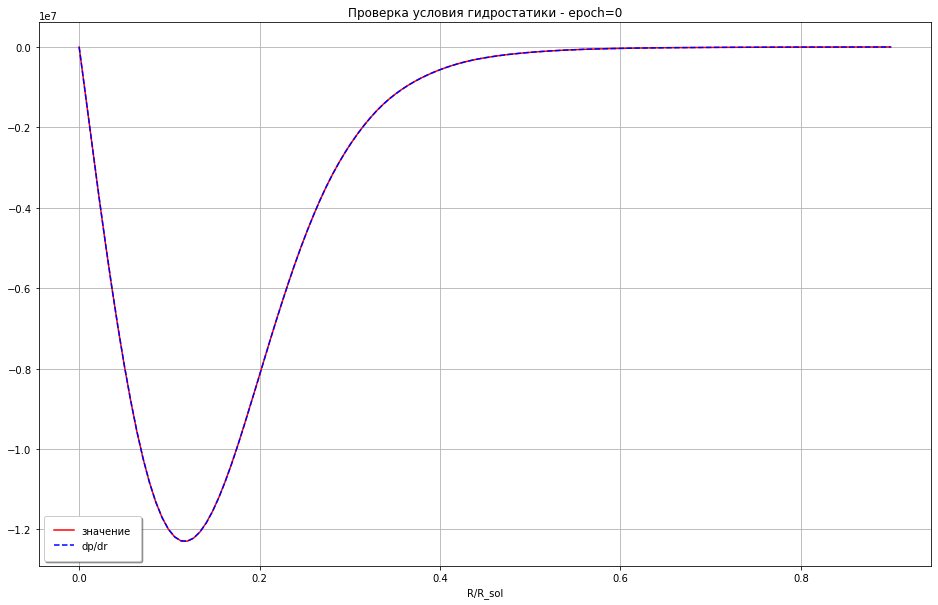

In [114]:
r1 = r[::70]/s.R
a1 = a[::70]
da1 = da[::70]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, a1, color='red', label='значение')
plt.plot(r1, da1, '--', color='blue', label='dp/dr')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Проверка условия гидростатики - epoch=%d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

Условие переноса энергии

In [121]:
for i in range(1, dimM-1):
    br[i] = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
    if abs(br[i]) < abs(bc[i]):
        b[i] = br[i]
    else:
        b[i] = bc[i]
    db[i] = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1]) # - b[i]
    print(i, b[i], db[i], pow((b[i] - db[i])/b[i], 2))

1 -4.667459781586986e-06 -2.3337298907853406e-06 0.2500000000017466
2 -5.014653571401459e-06 -4.841056676319233e-06 0.0011984006463456114
3 -5.3903091509254735e-06 -5.202481360977579e-06 0.001214205928003431
4 -5.786037041016208e-06 -5.588173096191309e-06 0.0011694210515237502
5 -6.1963273714564006e-06 -5.991182206252098e-06 0.001096109299966262
6 -6.617439815872177e-06 -6.406883593520214e-06 0.0010124093795197719
7 -7.046762603630384e-06 -6.8321012096993365e-06 0.0009279586160390985
8 -7.482426996274298e-06 -7.264594799951361e-06 0.0008475379705778389
9 -7.923067144292429e-06 -7.702747070439289e-06 0.0007732527339916538
10 -8.36766587408157e-06 -8.145366509273733e-06 0.0007057774577587221
11 -8.815452972810212e-06 -8.59155942346023e-06 0.0006450507677077675
12 -9.26583649285115e-06 -9.040644732785636e-06 0.0005906575043490184
13 -9.718355367413645e-06 -9.49209592995587e-06 0.000542035654190575
14 -1.0172646101435916e-05 -9.945500734524437e-06 0.0004985857867780392
15 -1.06284189533358

259 -0.0001225748180463096 -0.00012235190394326468 3.307292279014858e-06
260 -0.0001230204796373408 -0.00012279764884191662 3.280919609395426e-06
261 -0.00012346597385958847 -0.00012324322674840945 3.2548395763537334e-06
262 -0.00012391129995800937 -0.00012368863690871983 3.2290478310315315e-06
263 -0.00012435645717627885 -0.00012413387856721855 3.2035401143221736e-06
264 -0.00012480144475678773 -0.00012457895096640325 3.178312262293931e-06
265 -0.0001252462619406385 -0.00012502385334850385 3.1533601582046278e-06
266 -0.00012569090796764212 -0.0001254685849544121 3.1286797619522687e-06
267 -0.0001261353820763142 -0.00012591314502207607 3.104267153128158e-06
268 -0.00012657968350387146 -0.00012635753278984508 3.080118434854174e-06
269 -0.0001270238114862288 -0.0001268017474949981 3.0562297744239665e-06
270 -0.0001274677652579956 -0.0001272457883722716 3.0325974421303933e-06
271 -0.00012791154405247218 -0.00012768965465533174 3.0092177685165114e-06
272 -0.0001283551471016468 -0.000128133

508 -0.0002262387598473661 -0.00022605002157044887 6.959626750262211e-07
509 -0.00022661583796668917 -0.00022642729890709422 6.921849544037022e-07
510 -0.00022699251654135737 -0.00022680417725417612 6.884283798653221e-07
511 -0.00022736879445987423 -0.00022718065550053043 6.84692793295199e-07
512 -0.00022774467060947113 -0.00022755673253459149 6.80978031783889e-07
513 -0.00022812014387611255 -0.00022793240724278656 6.772839393701253e-07
514 -0.00022849521314449833 -0.00022830767851047238 6.736103601951049e-07
515 -0.00022886987729806946 -0.00022868254522126618 6.699571433418363e-07
516 -0.00022924413521901052 -0.0002290570062582499 6.663241341850041e-07
517 -0.00022961798578825625 -0.00022943106050370263 6.627111764295432e-07
518 -0.00022999142788549426 -0.00022980470683709342 6.591181263527287e-07
519 -0.0002303644603891685 -0.00023017794413722237 6.555448375213222e-07
520 -0.00023073708217648576 -0.00023055077128288946 6.519911562280772e-07
521 -0.00023110929212341892 -0.000230923187

819 -0.00032396457538612995 -0.0003237932283375091 2.797423434634318e-07
820 -0.00032430687631923317 -0.0003241357258527711 2.7851196660807924e-07
821 -0.00032464878253739895 -0.00032447782942835216 2.7728504678324464e-07
822 -0.00032499029248865015 -0.000324819537512851 2.760615730196537e-07
823 -0.00032533140461971246 -0.0003251608485540632 2.7484153282178e-07
824 -0.0003256721173760217 -0.0003255017609979112 2.7362491565371803e-07
825 -0.0003260124292017307 -0.00032584227328897914 2.724117112184237e-07
826 -0.0003263523385397203 -0.00032618238387064713 2.7120190906076835e-07
827 -0.00032669184383160533 -0.0003265220911856259 2.699954968893135e-07
828 -0.00032703094351774545 -0.00032686139367475313 2.6879246445733485e-07
829 -0.00032736963603725085 -0.00032720028977752824 2.675928018589847e-07
830 -0.0003277079198279938 -0.0003275387779326478 2.6639649787351803e-07
831 -0.0003280457933266134 -0.00032787685657747025 2.6520354168404787e-07
832 -0.0003283832549685289 -0.0003282145241476

1111 -0.00040153524442505134 -0.0004014601776712232 3.4950060285593336e-08
1112 -0.00040168442910895955 -0.00040160983676684953 3.448406803355675e-08
1113 -0.00040183266365815363 -0.00040175854638339306 3.402110474327766e-08
1114 -0.0004019799467649451 -0.00040190630521151594 3.356117099851256e-08
1115 -0.00040212627712500734 -0.00040205311194509163 3.310426755270775e-08
1116 -0.00040227165343739723 -0.0004021989652813391 3.2650395223077795e-08
1117 -0.0004024160744045849 -0.00040234386392109015 3.219955467777813e-08
1118 -0.0004025595387324765 -0.0004024878065685217 3.175174669983685e-08
1119 -0.00040270204513044046 -0.0004026307919314238 3.1306971971693696e-08
1120 -0.000402843592311335 -0.0004027728187209316 3.0865231338609874e-08
1121 -0.0004029841789915313 -0.0004029138856513918 3.0426525939306264e-08
1122 -0.0004031238038909402 -0.0004030539914410315 2.999085664508861e-08
1123 -0.0004032624657330394 -0.0004031931348119584 2.9558224093726205e-08
1124 -0.0004034001632448972 -0.0004

1383 -0.00043836785494299216 -0.00043831065702211946 1.7024841785792674e-08
1384 -0.00043848120771856116 -0.00043842453133065957 1.670714945022472e-08
1385 -0.00043859351613020615 -0.00043853736192445624 1.6392310194619807e-08
1386 -0.00043870477888531 -0.00043864914750795403 1.6080327688827552e-08
1387 -0.0004388149946961305 -0.0004387598867906825 1.5771205490941807e-08
1388 -0.00043892416227982065 -0.00043886957848792487 1.5464946685974747e-08
1389 -0.0004390322803584485 -0.0004389782213191127 1.5161554822659555e-08
1390 -0.0004391393476590135 -0.00043908581400889607 1.4861033306446216e-08
1391 -0.00043924536291346946 -0.0004391923552863407 1.4563385861853492e-08
1392 -0.00043935032485873727 -0.0004392978438859988 1.4268615942041617e-08
1393 -0.00043945423223673265 -0.0004394022785479085 1.3976726759122708e-08
1394 -0.0004395570837943786 -0.00043950565801558736 1.3687722373290294e-08
1395 -0.0004396588782836266 -0.000439607981038708 1.3401606251512233e-08
1396 -0.0004397596144614782 

1700 -0.0004351074790822402 -0.00043516768098463595 1.9143764083896473e-08
1701 -0.00043498588093300323 -0.00043504668000775076 1.953635863573611e-08
1702 -0.0004348630887217278 -0.0004349244848273737 1.993317855355772e-08
1703 -0.00043473910274044307 -0.0004348010957309302 2.0334231533016346e-08
1704 -0.00043461392329071773 -0.0004346765130154799 2.073952535855717e-08
1705 -0.0004344875506836891 -0.0004345507369871819 2.114906752898646e-08
1706 -0.0004343599852400804 -0.0004344237679619631 2.1562865682197135e-08
1707 -0.0004342312272902266 -0.00043429560626525134 2.198092740151044e-08
1708 -0.00043410127717409747 -0.0004341662522321085 2.240326028789617e-08
1709 -0.0004339701352413186 -0.00043403570620763256 2.28298722252941e-08
1710 -0.000433837801851198 -0.0004339039685464218 2.326077099832518e-08
1711 -0.00043370427737274476 -0.0004337710396121738 2.369596398802539e-08
1712 -0.00043356956218469444 -0.00043363691977875565 2.4135458900713013e-08
1713 -0.00043343365667553025 -0.000433

2002 -0.0004040743417336755 -0.0004041887675169802 8.019092811574099e-08
2003 -0.00040384437230448796 -0.00040395935701912847 8.106850292218226e-08
2004 -0.00040361328650429207 -0.00040372882940439803 8.195125703504364e-08
2005 -0.0004033810858349363 -0.00040349718616959564 8.283919726604057e-08
2006 -0.00040314777180866095 -0.00040326442882183125 8.373233029828825e-08
2007 -0.00040291334594810596 -0.0004030305588783846 8.463066247817664e-08
2008 -0.0004026778097863254 -0.0004027955778672403 8.553420056121845e-08
2009 -0.0004024411648667958 -0.0004025594873265524 8.6442950929763e-08
2010 -0.0004022034127434276 -0.00040232228880504616 8.735692015495518e-08
2011 -0.0004019645549805754 -0.0004020839838620179 8.827611498721736e-08
2012 -0.00040172459315304746 -0.0004018445740667996 8.920054155033948e-08
2013 -0.0004014835288461153 -0.000401604060999562 9.013020651077333e-08
2014 -0.0004012413636555246 -0.00040136244625091317 9.106511647173327e-08
2015 -0.00040099809918750333 -0.00040111973

2258 -0.00037357634275212413 -0.00037368125734193753 7.887021809624738e-08
2259 -0.00037336542260735196 -0.0003734708826796248 7.978255464838673e-08
2260 -0.00037315341325186733 -0.0003732594179295956 8.070031373588025e-08
2261 -0.00037294031644889757 -0.0003730468648504573 8.162349893307263e-08
2262 -0.00037272613397037574 -0.00037283322520964866 8.255211400414571e-08
2263 -0.0003725108675969507 -0.00037261850078364075 8.348616320478261e-08
2264 -0.0003722945191179976 -0.00037240269335746853 8.442565054925035e-08
2265 -0.0003720770903316257 -0.0003721858047247977 8.53705798946491e-08
2266 -0.0003718585830446883 -0.0003719678366881254 8.632095523685628e-08
2267 -0.0003716389990727926 -0.00037174879105871374 8.727678059242951e-08
2268 -0.00037141834024030564 -0.00037152866965652195 8.823805988102388e-08
2269 -0.0003711966083803665 -0.0003713074743103413 8.920479711897657e-08
2270 -0.00037097380533489266 -0.0003710852068576603 9.017699619287083e-08
2271 -0.00037074993295458763 -0.0003708

2579 -0.0003267729758686448 -0.0003268907553459459 1.2991131500284408e-07
2580 -0.0003265364925434506 -0.0003266547342061852 1.311226172811232e-07
2581 -0.00032629908713137335 -0.0003264177898374579 1.3233950988626659e-07
2582 -0.00032606076192320284 -0.0003261799245271912 1.3356199330873378e-07
2583 -0.00032582151921668534 -0.0003259411405699713 1.3479006847361872e-07
2584 -0.0003255813613165205 -0.0003257014402666065 1.3602373463648175e-07
2585 -0.0003253402905343566 -0.0003254608259253316 1.3726299209250468e-07
2586 -0.00032509830918879014 -0.0003252192998615404 1.385078415916516e-07
2587 -0.0003248554196053584 -0.0003249768643970494 1.39758282673777e-07
2588 -0.00032461162411653773 -0.0003247335218609011 1.410143154977015e-07
2589 -0.0003243669250617379 -0.0003244892745891629 1.4227594040365166e-07
2590 -0.00032412132478729853 -0.00032424412492459276 1.4354315714352448e-07
2591 -0.00032387482564648253 -0.00032399807521683996 1.448159653528455e-07
2592 -0.0003236274299994725 -0.0003

2867 -0.00031640837290577414 -0.0003164460261753792 1.4161506402529238e-08
2868 -0.00031633207234042467 -0.0003163702226231201 1.454484401060474e-08
2869 -0.00031625477901986974 -0.00031629342568018635 1.493309217970486e-08
2870 -0.0003161764942179129 -0.0003162156366189171 1.5326245022677603e-08
2871 -0.00031609721921116804 -0.0003161368567145285 1.57242968201304e-08
2872 -0.0003160169552790781 -0.0003160570872451136 1.6127242008149867e-08
2873 -0.0003159357037039268 -0.00031597632949150855 1.6535075061478683e-08
2874 -0.0003158534657708525 -0.0003158945847373595 1.69477905319068e-08
2875 -0.0003157702427678644 -0.0003158118542692565 1.736538314322662e-08
2876 -0.00031568603598585695 -0.0003157281393768673 1.778784789546582e-08
2877 -0.00031560084671862384 -0.0003156434413523349 1.821517954699563e-08
2878 -0.0003155146762628728 -0.00031555776149074644 1.864737298499649e-08
2879 -0.00031542752591823964 -0.0003154711010904672 1.9084423506796968e-08
2880 -0.00031533939698730526 -0.000315

3124 -0.00026832913009731274 -0.00026846849414146636 2.697527218899348e-07
3125 -0.00026804986169266755 -0.00026818949589505793 2.7136413122053833e-07
3126 -0.0002677700552993411 -0.0002679099584959084 2.7298026972086704e-07
3127 -0.0002674897132491921 -0.0002676298842742643 2.746011352442783e-07
3128 -0.00026720883787797453 -0.00026734927556358395 2.7622672286566465e-07
3129 -0.0002669274315253175 -0.00026706813470167427 2.778570293944585e-07
3130 -0.00026664549653470737 -0.00026678646403002207 2.794920508306264e-07
3131 -0.0002663630352534657 -0.0002665042658939947 2.8113178323449693e-07
3132 -0.00026608005003273 -0.0002662215426431075 2.8277622387570946e-07
3133 -0.00026579654322743363 -0.0002659382966301543 2.844253678479237e-07
3134 -0.0002655125171962831 -0.00026565453021187634 2.860792108134623e-07
3135 -0.0002652279743017399 -0.00026537024574902916 2.87737749359451e-07
3136 -0.0002649429169099969 -0.00026508544560584733 2.8940097893845786e-07
3137 -0.0002646573473909577 -0.0002

3382 -0.0002460384543603372 -0.00024598874952737776 4.081231754715427e-08
3383 -0.0002461369862916803 -0.0002460877203260115 4.0062702513351826e-08
3384 -0.00024623464137833614 -0.0002461858138350379 3.9321623892121036e-08
3385 -0.0002463314205107918 -0.00024628303094456595 3.8589027643262695e-08
3386 -0.00024642732458027365 -0.00024637937254550727 3.7864860133286474e-08
3387 -0.00024652235447873114 -0.00024647483952944276 3.7149068318248886e-08
3388 -0.0002466165110988177 -0.0002465694327888229 3.644159939501903e-08
3389 -0.0002467097953338751 -0.0002466631532164328 3.574240160488943e-08
3390 -0.00024680220807791537 -0.00024675600170586044 3.5051423463564654e-08
3391 -0.0002468937502256042 -0.00024684797915176424 3.436861333966452e-08
3392 -0.0002469844226722465 -0.0002469390864489365 3.369392085256937e-08
3393 -0.0002470742263137679 -0.0002470293244929722 3.302729581799233e-08
3394 -0.00024716316204670093 -0.0002471186941803363 3.236868813867624e-08
3395 -0.00024725123076816844 -0.00

3678 -0.00024083166363234433 -0.00024089172607543341 6.219834308128006e-08
3679 -0.00024071094183584336 -0.0002407713027341136 6.288104116906086e-08
3680 -0.00024058962421471479 -0.00024065028302526723 6.356733325226452e-08
3681 -0.00024046771185642945 -0.0002405286680355711 6.425721986934103e-08
3682 -0.0002403452058503431 -0.00024040645885337465 6.495070115669365e-08
3683 -0.00024022210728770807 -0.00024028365656896764 6.564777738129762e-08
3684 -0.00024009841726168154 -0.00024016026227471378 6.634844921214507e-08
3685 -0.0002399741368673358 -0.0002400362770646495 6.705271684240174e-08
3686 -0.0002398492672016673 -0.0002399117020344838 6.776057995415895e-08
3687 -0.00023972380936360593 -0.00023978653828253508 6.847203972699663e-08
3688 -0.00023959776445402688 -0.0002396607869087943 6.918709679735175e-08
3689 -0.0002394711335757566 -0.0002395344490148582 6.990575108022884e-08
3690 -0.00023934391783358454 -0.00023940752570466512 7.062800335544437e-08
3691 -0.0002392161183342717 -0.0002

3924 -0.00019617355652822003 -0.00019628793500549822 3.399442420888346e-07
3925 -0.00019594453791037922 -0.00019605904721926588 3.415193094021543e-07
3926 -0.00019571525925204494 -0.000195829898581155 3.43097771148194e-07
3927 -0.00019548572217751355 -0.0001956004907148248 3.4467962152543623e-07
3928 -0.00019525592831238015 -0.00019537082524493808 3.462648528373921e-07
3929 -0.00019502587928352241 -0.0001951409037979641 3.478534604136241e-07
3930 -0.00019479557671908242 -0.00019491072800130872 3.494454374946222e-07
3931 -0.0001945650222484491 -0.00019468029948384983 3.5104077856350896e-07
3932 -0.00019433421750224053 -0.0001944496198754019 3.5263947620421987e-07
3933 -0.00019410316411228569 -0.00019421869080725137 3.5424152446453086e-07
3934 -0.00019387186371160712 -0.00019398751391195586 3.558469177531601e-07
3935 -0.00019364031793440154 -0.00019375609082300966 3.5745564890089e-07
3936 -0.00019340852841602326 -0.00019352442317524518 3.5906771172426204e-07
3937 -0.00019317649679296477 

4231 -0.00014368884021245972 -0.00014359359829479177 4.393495477285328e-07
4232 -0.00014387876610073147 -0.00014378380315651282 4.356271437030777e-07
4233 -0.00014406813407226782 -0.00014397345008643013 4.319338107174315e-07
4234 -0.0001442569441638485 -0.00014416253911813016 4.282693136578721e-07
4235 -0.00014444519641871616 -0.0001443510702913547 4.246334225232721e-07
4236 -0.00014463289088651355 -0.00014453904365253602 4.21025906954212e-07
4237 -0.000144820027623224 -0.00014472645925486398 4.1744653514968554e-07
4238 -0.00014500660669110942 -0.0001449133171572152 4.138950828926057e-07
4239 -0.00014519262815864968 -0.00014509961742488936 4.10371326344723e-07
4240 -0.00014537809210048174 -0.00014528536012954206 4.068750421256205e-07
4241 -0.0001455629985973418 -0.00014547054534891737 4.0340600916264e-07
4242 -0.00014574734773600392 -0.00014565517316664697 3.9996400987295885e-07
4243 -0.00014593113960922164 -0.00014583924367258475 3.965488267089399e-07
4244 -0.0001461143743156697 -0.00

4448 -0.0001722801786163582 -0.00017224178270620145 4.967058864794212e-08
4449 -0.00017235649718130017 -0.00017231833789880315 4.90168142450511e-08
4450 -0.0001724323430085599 -0.00017239442009481484 4.836886957582276e-08
4451 -0.00017250771661571774 -0.00017247002981215094 4.772671625723982e-08
4452 -0.0001725826185201807 -0.00017254516756805678 4.709031749289308e-08
4453 -0.0001726570492391716 -0.00017261983387971072 4.645963649506161e-08
4454 -0.00017273100928972228 -0.00017269402926449194 4.5834635811278594e-08
4455 -0.00017280449918866326 -0.0001727677542392443 4.521527914292133e-08
4456 -0.00017287751945261584 -0.00017284100932067785 4.4601530311984185e-08
4457 -0.00017295007059798148 -0.000172913795025302 4.399335340115873e-08
4458 -0.0001730221531409355 -0.00017298611186942537 4.339071273794021e-08
4459 -0.00017309376759741706 -0.00017305796036915584 4.279357286967728e-08
4460 -0.00017316491448312162 -0.0001731293410402 4.220189902209874e-08
4461 -0.00017323559431349145 -0.0001

4727 -0.00017698241002520797 -0.00017700083242664407 1.0835083780960709e-08
4728 -0.00017694521761410785 -0.0001769638138196308 1.104513468703953e-08
4729 -0.0001769076779858627 -0.0001769264478000261 1.1257101480816625e-08
4730 -0.00017686979153143763 -0.00017688873475869106 1.1470982330552468e-08
4731 -0.00017683155864170382 -0.0001768506750865537 1.1686775638805223e-08
4732 -0.0001767929797074443 -0.00017681226917457547 1.1904480002930884e-08
4733 -0.00017675405511935778 -0.00017677351741341677 1.212409380069326e-08
4734 -0.00017671478526806597 -0.0001767344201937045 1.2345615504716794e-08
4735 -0.00017667517054411718 -0.00017669497790603214 1.2569043680521967e-08
4736 -0.00017663521133799243 -0.00017665519094109354 1.2794377152099784e-08
4737 -0.0001765949080401108 -0.00017661505968908075 1.3021614226520633e-08
4738 -0.00017655426104083353 -0.0001765745845404534 1.3250753666152153e-08
4739 -0.00017651327073047132 -0.00017653376588563772 1.3481794301861535e-08
4740 -0.00017647193749

4965 -0.00015922663688526048 -0.0001592806635330158 1.1512896438971595e-07
4966 -0.00015911833832582664 -0.00015917248760551433 1.1580968974388896e-07
4967 -0.00015900979502001466 -0.00015906406667290238 1.1649260088323896e-07
4968 -0.00015890100748644406 -0.0001589554012532282 1.1717769969780584e-07
4969 -0.00015879197624480158 -0.00015884649186561034 1.1786498808712067e-07
4970 -0.00015868270181584326 -0.00015873733903030496 1.1855446824317306e-07
4971 -0.00015857318472139805 -0.0001586279432685382 1.192461419096123e-07
4972 -0.000158463425484369 -0.00015851830510287438 1.1994001197817502e-07
4973 -0.0001583534246287373 -0.00015840842505664718 1.2063607999588212e-07
4974 -0.00015824318267956245 -0.00015829830365412704 1.2133434687701368e-07
4975 -0.0001581327001629868 -0.00015818794142118998 1.220348158266207e-07
4976 -0.00015802197760623695 -0.00015807733888461537 1.2273748926157738e-07
4977 -0.00015791101553762614 -0.00015796649657198543 1.2344236833879855e-07
4978 -0.0001577998144

5201 -0.0001281433114810733 -0.00012821790966447495 3.3889457585139957e-07
5202 -0.0001279940218064612 -0.00012806866664376548 3.4011061006289895e-07
5203 -0.0001278446395714368 -0.00012791933068897224 3.4132874872690743e-07
5204 -0.0001276951655237885 -0.00012776990254766217 3.4254898780611176e-07
5205 -0.00012754560041174895 -0.00012762038296777034 3.4377132248969774e-07
5206 -0.00012739594498398647 -0.00012747077269783383 3.449957494162502e-07
5207 -0.00012724619998959768 -0.00012732107248679126 3.4622226491156626e-07
5208 -0.00012709636617809974 -0.00012717128308384877 3.4745086381199586e-07
5209 -0.00012694644429942165 -0.00012702140523874783 3.486815420158345e-07
5210 -0.00012679643510389663 -0.00012687143970166478 3.4991429563253245e-07
5211 -0.00012664633934225447 -0.0001267213872230435 3.511491194929619e-07
5212 -0.00012649615776561248 -0.00012657124855389667 3.523860100422543e-07
5213 -0.0001263458911254686 -0.000126421024445538 3.5362496290930523e-07
5214 -0.0001261955401736

5448 -0.00012412527706682724 -0.00012409420934169225 6.26467357204805e-08
5449 -0.00012418712462224896 -0.0001241562008444921 6.20057469235731e-08
5450 -0.00012424868457702393 -0.000124217904599627 6.136955781140026e-08
5451 -0.00012430995722515612 -0.00012427932090107913 6.073813825940905e-08
5452 -0.00012437094286054434 -0.00012434045004286405 6.011145783250335e-08
5453 -0.00012443164177697812 -0.0001244012923187967 5.9489486700217905e-08
5454 -0.00012449205426813084 -0.00012446184802249118 5.8872195597774165e-08
5455 -0.00012455218062755382 -0.00012452211744782925 5.825955397620083e-08
5456 -0.000124612021148672 -0.00012458210088815756 5.76515331203008e-08
5457 -0.00012467157612477706 -0.00012464179863672217 5.704810440984239e-08
5458 -0.00012473084584902218 -0.00012470121098683622 5.644923866245284e-08
5459 -0.00012478983061441748 -0.00012476033823171246 5.5854906771362276e-08
5460 -0.00012484853071382404 -0.00012481918066416215 5.526508081901354e-08
5461 -0.00012490694643994813 -0

5697 -0.000131347294793382 -0.000131347929981394 2.3386343312843406e-11
5698 -0.00013134579894795602 -0.00013134654687069246 3.242508314004002e-11
5699 -0.00013134407783016753 -0.00013134493838902697 4.292795189847924e-11
5700 -0.00013134213163672618 -0.00013134310473343386 5.4891346650846623e-11
5701 -0.00013133996056396733 -0.00013134104610034721 6.831168567766656e-11
5702 -0.00013133756480785178 -0.00013133876268586663 8.318543064630511e-11
5703 -0.0001313349445639695 -0.00013133625468589105 9.950910881640098e-11
5704 -0.00013133210002754013 -0.00013133352229578407 1.1727926865870132e-10
5705 -0.00013132903139341558 -0.00013133056571054132 1.3649249824723035e-10
5706 -0.00013132573885608144 -0.00013132738512472365 1.571454120509812e-10
5707 -0.00013132222260965913 -0.0001313239807328584 1.7923472770413143e-10
5708 -0.0001313184828479079 -0.00013132035272880378 2.02757149010747e-10
5709 -0.00013131451976422642 -0.00013131650130601664 2.277094070386869e-10
5710 -0.0001313103335516543 

5939 -0.00012483771070883001 -0.0001248630318582933 4.114103769849003e-08
5940 -0.0001247868853156028 -0.00012481229801220023 4.147282442993692e-08
5941 -0.00012473587700956903 -0.00012476138116255934 4.180604079694311e-08
5942 -0.00012468468597250237 -0.0001247102814910187 4.214068902160823e-08
5943 -0.00012463331238649365 -0.00012465899917952738 4.247677129040422e-08
5944 -0.00012458175643395382 -0.00012460753441020182 4.281428929898313e-08
5945 -0.0001245300182976169 -0.000124555887365794 4.315324579344268e-08
5946 -0.00012447809816054422 -0.0001245040582291228 4.349364267318663e-08
5947 -0.00012442599620612655 -0.00012445204718330817 4.3835481753321946e-08
5948 -0.00012437371261808837 -0.0001243998544120722 4.417876576530967e-08
5949 -0.00012432124758049088 -0.0001243474800992709 4.452349677724913e-08
5950 -0.00012426860127773482 -0.00012429492442912808 4.4869676966685695e-08
5951 -0.0001242157738945649 -0.00012424218758616876 4.521730837973626e-08
5952 -0.0001241627656160715 -0.00

6169 -0.0001238477102594943 -0.00012380209831325552 1.356379584277452e-07
6170 -0.00012393886297704188 -0.00012389328661829705 1.3522725573425262e-07
6171 -0.00012402994511306973 -0.00012398440404507417 1.3481968847293684e-07
6172 -0.0001241209572621777 -0.00012407545118763957 1.3441524098588822e-07
6173 -0.00012421190002012285 -0.00012416642864114985 1.3401389805129782e-07
6174 -0.00012430277398382323 -0.0001242573370019659 1.3361564431116012e-07
6175 -0.0001243935797513641 -0.00012434817686758604 1.3322046470182128e-07
6176 -0.00012448431792200153 -0.00012443894883667938 1.328283442777887e-07
6177 -0.00012457498909616908 -0.00012452965350908592 1.324392682483238e-07
6178 -0.00012466559387548095 -0.00012462029148581648 1.3205322199586204e-07
6179 -0.00012475613286273919 -0.00012471086336911962 1.316701907269581e-07
6180 -0.00012484660666193777 -0.00012480136976234787 1.3129016027505053e-07
6181 -0.00012493701587826822 -0.00012489181127012494 1.3091311615787127e-07
6182 -0.000125027361

6378 -0.00014236969978521287 -0.00014232389580303852 1.0350738469610386e-07
6379 -0.00014246139952029952 -0.00014241554965275133 1.0358139552818382e-07
6380 -0.00014255319210383028 -0.00014250729581208674 1.0365763637840644e-07
6381 -0.000142645078618008 -0.00014259913536093075 1.0373611416214295e-07
6382 -0.0001427370601495204 -0.00014269106938375224 1.0381683540061808e-07
6383 -0.00014282913778957535 -0.0001427830989695363 1.0389980668146087e-07
6384 -0.00014292131263393446 -0.00014287522521171716 1.0398503511315411e-07
6385 -0.00014301358578294816 -0.0001429674492084793 1.040725271248475e-07
6386 -0.00014310595834159128 -0.00014305977206232278 1.041622905883145e-07
6387 -0.0001431984314194971 -0.0001431521948805646 1.0425433270890343e-07
6388 -0.00014329100613099454 -0.00014324471877527227 1.0434866049434593e-07
6389 -0.00014338368359514318 -0.0001433373448630961 1.0444528166879704e-07
6390 -0.00014347646493576994 -0.00014343007426547024 1.0454420393138709e-07
6391 -0.00014356935128

6567 -0.00016286806343557522 -0.00016280028228122801 1.7319926978555422e-07
6568 -0.00016300406097081766 -0.00016293606220319033 1.7402243260036367e-07
6569 -0.00016314049682034 -0.00016307227889556924 1.7485314431181443e-07
6570 -0.00016327737409403982 -0.00016320893545718678 1.7569147424943112e-07
6571 -0.0001634146959242059 -0.00016334603500907743 1.7653749291148064e-07
6572 -0.00016355246546573775 -0.00016348358069499016 1.7739127051584699e-07
6573 -0.00016369068589636954 -0.0001636215756810538 1.782528798768159e-07
6574 -0.00016382936041689223 -0.00016376002315661317 1.791223932507108e-07
6575 -0.00016396849225138352 -0.00016389892633419603 1.7999988368977736e-07
6576 -0.00016410808464743673 -0.00016403828844941225 1.808854267545599e-07
6577 -0.00016424814087639408 -0.00016417811276189093 1.8177909687733617e-07
6578 -0.00016438866423358248 -0.00016431840255494556 1.8268097031732617e-07
6579 -0.00016452965803855177 -0.00016445916113610936 1.835911236250978e-07
6580 -0.0001646711256

6845 -0.00016673344367518935 -0.0001667559983809084 1.8299064583562874e-08
6846 -0.00016668835130818565 -0.00016671089749169756 1.8295133083759216e-08
6847 -0.00016664327597653366 -0.00016666581364234456 1.8291203453533594e-08
6848 -0.000166598217671198 -0.00016662074682383392 1.8287275729081454e-08
6849 -0.00016655317638314973 -0.00016657569702716688 1.828334996329909e-08
6850 -0.00016650815210336666 -0.0001665306642432443 1.827942603520117e-08
6851 -0.00016646314482283303 -0.00016648564846306738 1.8275503976178414e-08
6852 -0.00016641815453253967 -0.00016644064967770428 1.8271583915742476e-08
6853 -0.00016637318122348388 -0.00016639566787805585 1.826766570115209e-08
6854 -0.00016632822488666965 -0.00016635070305505645 1.8263749223125383e-08
6855 -0.00016628328551310739 -0.00016630575519984109 1.8259834687993706e-08
6856 -0.00016623836309381405 -0.00016626082430349465 1.8255922210089482e-08
6857 -0.00016619345761981316 -0.00016621591035681765 1.8252011430792858e-08
6858 -0.00016614856

7039 -0.00015829398147000122 -0.00015831496372424874 1.7570150633418503e-08
7040 -0.00015825203236835211 -0.00015827300691918268 1.7566560913880403e-08
7041 -0.00015821009866570524 -0.0001582310655170345 1.7562972798783592e-08
7042 -0.00015816818035420033 -0.0001581891395099429 1.7559386289754936e-08
7043 -0.00015812627742598274 -0.00015814722889006318 1.755580140695312e-08
7044 -0.00015808438987320323 -0.00015810533364958414 1.7552218217433037e-08
7045 -0.00015804251768801838 -0.00015806345378062766 1.7548636666560038e-08
7046 -0.00015800066086259012 -0.00015802158927529896 1.754505666257741e-08
7047 -0.00015795881938908605 -0.00015797974012582026 1.7541478300481158e-08
7048 -0.0001579169932596793 -0.0001579379063243971 1.7537901638003317e-08
7049 -0.0001578751824665485 -0.0001578960878631346 1.7534326555356637e-08
7050 -0.00015783338700187786 -0.00015785428473420493 1.7530753035585565e-08
7051 -0.0001577916068578571 -0.00015781249692983025 1.7527181136541324e-08
7052 -0.0001577498420

7292 -0.00014815167607231907 -0.00014817082765993886 1.6710768594228475e-08
7293 -0.00014811338648006283 -0.0001481325312761955 1.670755380699314e-08
7294 -0.00014807511046423163 -0.00014809424847213217 1.6704340285765214e-08
7295 -0.00014803684801823933 -0.00014805597924119217 1.6701128084680186e-08
7296 -0.00014799859913550452 -0.0001480177235768689 1.6697917337329692e-08
7297 -0.00014796036380945016 -0.00014797948147248857 1.669470787758877e-08
7298 -0.0001479221420335038 -0.00014794125292147777 1.6691499706642587e-08
7299 -0.00014788393380109758 -0.00014790303791731318 1.6688292905184152e-08
7300 -0.00014784573910566804 -0.00014786483645337119 1.668508737094785e-08
7301 -0.0001478075579406563 -0.00014782664852316195 1.668188322741404e-08
7302 -0.000147769390299508 -0.00014778847412009533 1.6678680414978064e-08
7303 -0.00014773123617567335 -0.00014775031323759782 1.667547889498655e-08
7304 -0.00014769309556260696 -0.00014771216586912945 1.667227867975446e-08
7305 -0.0001476549684537

7532 -0.0001393371505639784 -0.00013935476176264418 1.5975114605484832e-08
7533 -0.00013930194029048004 -0.00013931954542720882 1.597219020820034e-08
7534 -0.0001392667421352182 -0.0001392843412128498 1.596926697463471e-08
7535 -0.00013923155609260103 -0.0001392491491139303 1.596634482564798e-08
7536 -0.00013919638215704018 -0.00013921396912483034 1.5963423706207676e-08
7537 -0.00013916122032295127 -0.00013917880124001344 1.596050370578464e-08
7538 -0.00013912607058475361 -0.00013914364545384285 1.5957584724944334e-08
7539 -0.00013909093293687028 -0.00013910850176079888 1.5954666870113486e-08
7540 -0.00013905580737372825 -0.00013907337015531168 1.5951750149458748e-08
7541 -0.000139020693889758 -0.00013903825063174444 1.5948834443211104e-08
7542 -0.00013898559247939389 -0.0001390031431845775 1.594591983730299e-08
7543 -0.0001389505031370742 -0.00013896804780824093 1.5943006319296737e-08
7544 -0.00013891542585724067 -0.0001389329644971649 1.5940093870537257e-08
7545 -0.000138880360634339

7740 -0.0001322663061507007 -0.00013228271401490802 1.5388831919721985e-08
7741 -0.00013223350145954866 -0.00013224990380512772 1.5386113069121024e-08
7742 -0.00013220070780078466 -0.00013221710463014836 1.53833950695449e-08
7743 -0.0001321679251695452 -0.00013218431648516114 1.5380678025749855e-08
7744 -0.00013213515356096995 -0.00013215153936525686 1.5377961848212164e-08
7745 -0.00013210239297020172 -0.00013211877326560159 1.5375246582649966e-08
7746 -0.00013206964339238682 -0.00013208601818131963 1.537253218992127e-08
7747 -0.00013203690482267456 -0.00013205327410753529 1.5369818625156997e-08
7748 -0.00013200417725621754 -0.0001320205410394313 1.536710594705647e-08
7749 -0.00013197146068817165 -0.00013198781897219054 1.536439420839796e-08
7750 -0.00013193875511369603 -0.00013195510790095397 1.5361683377202708e-08
7751 -0.00013190606052795298 -0.00013192240782082082 1.5358973337074753e-08
7752 -0.0001318733769261081 -0.00013188971872702402 1.535626421661876e-08
7753 -0.00013184070430

8121 -0.00012284563178213665 -0.0001228560232717571 7.155437289856802e-09
8122 -0.00012282485355931448 -0.00012283524267071958 7.1545825122768785e-09
8123 -0.0001228040800915642 -0.00012281446682543435 7.153727879789817e-09
8124 -0.00012278331137752194 -0.00012279369573453943 7.1528733952238465e-09
8125 -0.0001227625474158244 -0.00012277292939666078 7.152019044155072e-09
8126 -0.00012274178820510892 -0.00012275216781046036 7.151164860706552e-09
8127 -0.00012272103374401356 -0.00012273141097456422 7.150310828701867e-09
8128 -0.00012270028403117697 -0.00012271065888758647 7.149456914549049e-09
8129 -0.00012267953906523851 -0.00012268991154818897 7.148603149574764e-09
8130 -0.000122658798844838 -0.00012266916895502166 7.147749548006064e-09
8131 -0.0001226380633686161 -0.00012264843110672258 7.14689610654992e-09
8132 -0.00012261733263521407 -0.00012262769800192968 7.146042820902662e-09
8133 -0.00012259660664327377 -0.0001226069696392571 7.1451896531563604e-09
8134 -0.00012257588539143767 -

8375 -0.00011771717429151435 -0.00011772698278617783 6.942646662836465e-09
8376 -0.00011769756173210457 -0.00011770736801179301 6.941824337297071e-09
8377 -0.0001176779536014105 -0.00011768775766675789 6.941002161615714e-09
8378 -0.00011765834989822468 -0.00011766815174981802 6.940180069541928e-09
8379 -0.00011763875062134026 -0.00011764855025977864 6.939358078462162e-09
8380 -0.000117619155769551 -0.00011762895319544501 6.938536204887218e-09
8381 -0.00011759956534165115 -0.00011760936055561048 6.937714447807247e-09
8382 -0.0001175799793364356 -0.00011758977233904442 6.93689277132559e-09
8383 -0.00011756039775269996 -0.00011757018854456406 6.9360712063337405e-09
8384 -0.00011754082058924021 -0.00011755060917097466 6.935249766222286e-09
8385 -0.00011752124784485312 -0.00011753103421704566 6.934428412511742e-09
8386 -0.00011750167951833589 -0.00011751146368159424 6.93360717380013e-09
8387 -0.00011748211560848638 -0.00011749189756340178 6.932786026945286e-09
8388 -0.00011746255611410306 -

8630 -0.00011416676917153837 -0.00011417335532313756 3.3280054127705674e-09
8631 -0.00011415359893452653 -0.00011416018405303909 3.3277291770551817e-09
8632 -0.00011414043076333971 -0.00011414701484894222 3.327452947089068e-09
8633 -0.00011412726465760017 -0.0001141338477104629 3.327176716551502e-09
8634 -0.00011411410061693045 -0.00011412068263725981 3.326900521988192e-09
8635 -0.00011410093864095307 -0.00011410751962894036 3.3266243481645826e-09
8636 -0.00011408777872929084 -0.00011409435868512058 3.3263481882685433e-09
8637 -0.00011407462088156664 -0.00011408119980542493 3.326072043940895e-09
8638 -0.00011406146509740345 -0.00011406804298947794 3.325795916781822e-09
8639 -0.0001140483113764244 -0.00011405488823692118 3.3255198254825803e-09
8640 -0.00011403515971825285 -0.0001140417355473621 3.3252437539942165e-09
8641 -0.00011402201012251216 -0.000114028584920374 3.324967651720369e-09
8642 -0.00011400886258882597 -0.00011401543635565823 3.324691597292686e-09
8643 -0.0001139957171168

8933 -0.00011041612698429326 -0.00011042053192265403 1.5915293506005896e-09
8934 -0.00011040731806896482 -0.00011041172252661654 1.5914359207006e-09
8935 -0.00011039851011489468 -0.00011040291409191688 1.5913425083939962e-09
8936 -0.00011038970312196688 -0.00011039410661843312 1.5912491093791453e-09
8937 -0.00011038089709006549 -0.00011038530010601898 1.5911557017222074e-09
8938 -0.00011037209201907456 -0.00011037649455457693 1.5910622987395736e-09
8939 -0.0001103632879088782 -0.00011036768996398503 1.5909688960780182e-09
8940 -0.0001103544847593606 -0.0001103588863341214 1.590875489344251e-09
8941 -0.00011034568257040595 -0.00011035008366487631 1.5907820829419453e-09
8942 -0.00011033688134189837 -0.00011034128195615223 1.590688690132745e-09
8943 -0.00011032808107372222 -0.00011033248120781505 1.590595297588783e-09
8944 -0.0001103192817657617 -0.00011032368141974288 1.5905019008962738e-09
8945 -0.00011031048341790117 -0.00011031488259181376 1.5904084954935525e-09
8946 -0.00011030168603

9204 -0.00010806370538493238 -0.00010806798212471797 1.5662675263422495e-09
9205 -0.00010805515283651097 -0.00010805942911072923 1.5661744315706895e-09
9206 -0.00010804660121913852 -0.00010805087702781972 1.5660813200166684e-09
9207 -0.00010803805053270818 -0.00010804232587592849 1.5659882252994674e-09
9208 -0.00010802950077711313 -0.00010803377565492142 1.5658951274403472e-09
9209 -0.00010802095195224656 -0.00010802522636468883 1.5658020243191025e-09
9210 -0.00010801240405800177 -0.00010801667800513316 1.5657089226524594e-09
9211 -0.00010800385709427204 -0.00010800813057614469 1.5656158202511722e-09
9212 -0.00010799531106095062 -0.00010799958407761372 1.5655227149354923e-09
9213 -0.00010798676595793096 -0.0001079910385094427 1.565429613334105e-09
9214 -0.00010797822178510645 -0.00010798249387152192 1.565336513168386e-09
9215 -0.00010796967854237041 -0.00010797395016374165 1.5652434121989907e-09
9216 -0.00010796113622961643 -0.00010796540738599217 1.5651503080172717e-09
9217 -0.0001079

9462 -0.00010612509960340424 -0.00010612801943381503 7.569706368147082e-10
9463 -0.0001061192603873459 -0.00010612217999537124 7.569386279229792e-10
9464 -0.00010611342161597365 -0.00010611634100165406 7.569066308537074e-10
9465 -0.00010610758328925378 -0.00010611050245261125 7.56874636001985e-10
9466 -0.00010610174540715244 -0.00010610466434819927 7.568426383297919e-10
9467 -0.00010609590796963587 -0.00010609882668840939 7.56810650839861e-10
9468 -0.00010609007097667032 -0.00010609298947314585 7.56778641357767e-10
9469 -0.00010608423442822188 -0.00010608715270245218 7.567466500581123e-10
9470 -0.00010607839832425692 -0.00010608131637624129 7.567146492073883e-10
9471 -0.00010607256266474165 -0.00010607548049447834 7.566826382641937e-10
9472 -0.00010606672744964227 -0.0001060696450571982 7.566506528393053e-10
9473 -0.00010606089267892508 -0.00010606381006429635 7.566186562132537e-10
9474 -0.00010605505835255636 -0.00010605797551574666 7.565866523154211e-10
9475 -0.00010604922447050241 -

9754 -0.00010443880539347479 -0.0001044416609936558 7.476029570179213e-10
9755 -0.0001044330946283862 -0.00010443595001094673 7.475707670668185e-10
9756 -0.00010442738429852082 -0.00010443023946344641 7.475385604991747e-10
9757 -0.00010442167440384772 -0.00010442452935118097 7.475063671706615e-10
9758 -0.00010441596494433596 -0.00010441881967408946 7.474741713703731e-10
9759 -0.0001044102559199547 -0.00010441311043215447 7.47441980153599e-10
9760 -0.00010440454733067305 -0.00010440740162531503 7.474097777436515e-10
9761 -0.00010439883917646012 -0.00010440169325354504 7.473775666670162e-10
9762 -0.00010439313145728505 -0.00010439598531686188 7.473453721713695e-10
9763 -0.000104387424173117 -0.00010439027781520462 7.473131785151389e-10
9764 -0.00010438171732392516 -0.0001043845707485297 7.472809790194757e-10
9765 -0.0001043760109096786 -0.00010437886411681973 7.472487807620341e-10
9766 -0.00010437030493034658 -0.00010437315792001373 7.472165679200625e-10
9767 -0.00010436459938589831 -0.0

10044 -0.00010316703985645257 -0.0001031690048030802 3.6276015405543565e-10
10045 -0.00010316311017441691 -0.0001031650750157199 3.627488999480691e-10
10046 -0.00010315918070238897 -0.00010316114543833452 3.6273763157070935e-10
10047 -0.00010315525144035921 -0.00010315721607163425 3.627266146840735e-10
10048 -0.00010315132238831788 -0.00010315328691426097 3.627153514052583e-10
10049 -0.00010314739354625522 -0.00010314935796721143 3.6270421339334736e-10
10050 -0.00010314346491416168 -0.00010314542923082199 3.6269332839204264e-10
10051 -0.0001031395364920275 -0.00010314150070369742 3.626821847813533e-10
10052 -0.000103135608279843 -0.00010313757238586265 3.626707953213563e-10
10053 -0.00010313168027759851 -0.00010313364427932324 3.6265990423541975e-10
10054 -0.00010312775248528437 -0.00010312971638203638 3.6264876068390853e-10
10055 -0.00010312382490289086 -0.00010312578869401448 3.6263737282334343e-10
10056 -0.00010311989753040837 -0.0001031218612165655 3.626262272657335e-10
10057 -0.00

10291 -0.00010222138284360904 -0.00010222274058702919 1.764216624078288e-10
10292 -0.00010221866745642614 -0.0001022200251494159 1.7641792959535584e-10
10293 -0.00010221595217104918 -0.00010221730981410029 1.764143240675622e-10
10294 -0.00010221323698747505 -0.00010221459457914199 1.7641034236325483e-10
10295 -0.00010221052190570074 -0.00010221187944648138 1.7640648952832553e-10
10296 -0.00010220780692572323 -0.00010220916441559782 1.764026310510119e-10
10297 -0.00010220509204753943 -0.00010220644948650908 1.7639877234483438e-10
10298 -0.00010220237727114637 -0.00010220373465923293 1.7639491880603998e-10
10299 -0.00010219966259654103 -0.00010220101993374273 1.7639106429181908e-10
10300 -0.00010219694802372033 -0.00010219830531002956 1.7638720728748912e-10
10301 -0.00010219423355268131 -0.00010219559078856953 1.7638347230678658e-10
10302 -0.00010219151918342089 -0.00010219287636842825 1.7637961729153515e-10
10303 -0.000102188804915936 -0.00010219016204861801 1.7637538630350805e-10
10304

10616 -0.00010134422535271259 -0.00010134556663059614 1.7516184549217667e-10
10617 -0.00010134154289852504 -0.00010134288412549382 1.751578197883959e-10
10618 -0.00010133886054521272 -0.00010134020172081681 1.7515367604627508e-10
10619 -0.00010133617829277294 -0.00010133751941792806 1.7514977097228406e-10
10620 -0.00010133349614120307 -0.00010133483721735297 1.751462424975478e-10
10621 -0.00010133081409050046 -0.0001013321551162234 1.7514234215453365e-10
10622 -0.00010132813214066235 -0.0001013294731154658 1.751383126468576e-10
10623 -0.00010132545029168611 -0.00010132679121605987 1.7513441056686757e-10
10624 -0.00010132276854356912 -0.00010132410941752465 1.7513051096657227e-10
10625 -0.00010132008689630863 -0.00010132142771983348 1.751266076046893e-10
10626 -0.00010131740534990205 -0.00010131874612299526 1.7512270347968026e-10
10627 -0.00010131472390434672 -0.00010131606462700107 1.751187969558952e-10
10628 -0.00010131204255963985 -0.00010131338323139671 1.7511477011005054e-10
10629 

10879 -0.00010077141064502543 -0.00010077234198444547 8.541640612183294e-11
10880 -0.000100769548014822 -0.00010077047932898546 8.541493098875568e-11
10881 -0.00010076768543378356 -0.00010076861672337221 8.541358078374004e-11
10882 -0.00010076582290190931 -0.00010076675416760572 8.541235566488505e-11
10883 -0.00010076396041919845 -0.00010076489166031932 8.541100508674315e-11
10884 -0.00010076209798565017 -0.00010076302920218366 8.540965221073055e-11
10885 -0.00010076023560126364 -0.000100761166793882 8.540842253051137e-11
10886 -0.00010075837326603809 -0.00010075930443406048 8.54070678368277e-11
10887 -0.00010075651097997264 -0.00010075744212274451 8.540559294629204e-11
10888 -0.00010075464874306658 -0.00010075557986127524 8.540424401498098e-11
10889 -0.00010075278655531905 -0.00010075371764894402 8.540289120452844e-11
10890 -0.0001007509244167292 -0.0001007518554857889 8.540154165017611e-11
10891 -0.00010074906232729631 -0.00010074999337244234 8.540031150803951e-11
10892 -0.0001007472

11152 -0.0001002647353809203 -0.00010026566002285326 8.504538393616907e-11
11153 -0.00010026288614418654 -0.00010026381076297292 8.50442631124726e-11
11154 -0.00010026103695641363 -0.00010026196154956808 8.504268496981286e-11
11155 -0.000100259742554107 -0.00010026038975692708 4.167039639350328e-11
11156 -0.00010025844817579109 -0.00010025909536662652 4.1669929067004804e-11
11157 -0.00010025715382146552 -0.00010025780099838372 4.166921284848765e-11
11158 -0.00010025585949113023 -0.00010025650665794521 4.1668987739430443e-11
11159 -0.00010025456518478487 -0.00010025521233960989 4.166851964059202e-11
11160 -0.00010025327090242925 -0.0001002539180433778 4.166780857632514e-11
11161 -0.0001002519766440631 -0.00010025262377299818 4.166733739067067e-11
11162 -0.00010025068240968621 -0.00010025132952757222 4.166699036611521e-11
11163 -0.00010024938819929839 -0.00010025003530424957 4.166640047050508e-11
11164 -0.00010024809401289932 -0.00010024874110585334 4.1665931296130705e-11
11165 -0.000100

11418 -9.992014692986936e-05 -9.992079098074091e-05 4.154647829964501e-11
11419 -9.991885885345709e-05 -9.991950289141605e-05 4.154588351768016e-11
11420 -9.991757080097918e-05 -9.991821482886909e-05 4.154565557191942e-11
11421 -9.991628277243555e-05 -9.991692678835927e-05 4.154518283370746e-11
11422 -9.991499476782583e-05 -9.991563876987747e-05 4.154446416819767e-11
11423 -9.991370678714994e-05 -9.991435077914158e-05 4.1544237307545186e-11
11424 -9.99124188304077e-05 -9.991306281043379e-05 4.1543764565057844e-11
11425 -9.991113089759884e-05 -9.99117748637723e-05 4.154304831349343e-11
11426 -9.990984298872321e-05 -9.991048694292046e-05 4.154257413430709e-11
11427 -9.990855510378064e-05 -9.990919904695558e-05 4.154222300138457e-11
11428 -9.990726724277091e-05 -9.990791117302797e-05 4.1541627264922694e-11
11429 -9.990597940569383e-05 -9.990662332397821e-05 4.154115345212612e-11
11430 -9.990469159254927e-05 -9.990533550077427e-05 4.154092647847802e-11
11431 -9.9903403803337e-05 -9.9904047

11694 -9.960592429094292e-05 -9.960637307940111e-05 2.0300793751941843e-11
11695 -9.960502672767253e-05 -9.960547550756635e-05 2.030038480425664e-11
11696 -9.960412917611016e-05 -9.960457795287839e-05 2.0300467893063285e-11
11697 -9.960323163625583e-05 -9.960368040716831e-05 2.0300303978899975e-11
11698 -9.960233410810934e-05 -9.960278287180185e-05 2.0300016634933537e-11
11699 -9.96014365916708e-05 -9.96018853508635e-05 2.0299975380220592e-11
11700 -9.960053908694005e-05 -9.960098783755029e-05 2.029956475424983e-11
11701 -9.959964159391705e-05 -9.960009033870395e-05 2.029940374225739e-11
11702 -9.959874411260184e-05 -9.95991928515412e-05 2.0299240534588326e-11
11703 -9.959784664299427e-05 -9.959829537740177e-05 2.0299196353274776e-11
11704 -9.959694918509437e-05 -9.959739791499771e-05 2.0299154671462896e-11
11705 -9.959605173890208e-05 -9.95965004629892e-05 2.0298994278692223e-11
11706 -9.959515430441729e-05 -9.959560302128567e-05 2.0298706983653965e-11
11707 -9.959425688163998e-05 -9.

11938 -9.938726584354464e-05 -9.93877132028991e-05 2.0260565341751744e-11
11939 -9.938637113576574e-05 -9.938681849063585e-05 2.0260523936177395e-11
11940 -9.938547643968508e-05 -9.938592378869328e-05 2.0260357747250614e-11
11941 -9.938458175530277e-05 -9.938502909711682e-05 2.0260070875727246e-11
11942 -9.938368708261858e-05 -9.938413441723683e-05 2.0259783847762324e-11
11943 -9.93827924216327e-05 -9.938323975039679e-05 2.0259618337367767e-11
11944 -9.938189777234493e-05 -9.938234509525324e-05 2.0259452673815543e-11
11945 -9.938100313475534e-05 -9.938145045451232e-05 2.0259531975151276e-11
11946 -9.938010850886388e-05 -9.938055582279416e-05 2.0259368933124325e-11
11947 -9.93792138946705e-05 -9.937966120274658e-05 2.0259203391968624e-11
11948 -9.93783192921752e-05 -9.937876659304578e-05 2.025891543923741e-11
11949 -9.937742470137785e-05 -9.937787199504146e-05 2.025862734601487e-11
11950 -9.937653012227857e-05 -9.937697741278296e-05 2.025870590353873e-11
11951 -9.937563555487727e-05 -9.

12252 -9.916841203996119e-05 -9.916872418634943e-05 9.907632984527551e-12
12253 -9.916778774906832e-05 -9.916809989068032e-05 9.907454526876292e-12
12254 -9.916716346390534e-05 -9.916747560264397e-05 9.907396863481324e-12
12255 -9.916653918447222e-05 -9.91668513261163e-05 9.907706046146673e-12
12256 -9.91659149107691e-05 -9.91662270476377e-05 9.907527630531623e-12
12257 -9.916529064279568e-05 -9.916560277294343e-05 9.90722571795576e-12
12258 -9.916466638055222e-05 -9.916497850973941e-05 9.907289475948464e-12
12259 -9.916404212403858e-05 -9.91643542465271e-05 9.906988967777234e-12
12260 -9.91634178732548e-05 -9.916372999673823e-05 9.907176859419447e-12
12261 -9.916279362820094e-05 -9.916310575072457e-05 9.907240662896587e-12
12262 -9.916216938887688e-05 -9.916248150469348e-05 9.906939615213849e-12
12263 -9.916154515528267e-05 -9.916185727017087e-05 9.907005408391803e-12
12264 -9.916092092741838e-05 -9.91612330413476e-05 9.907069259629558e-12
12265 -9.916029670528391e-05 -9.9160608816355

12438 -9.905239251538032e-05 -9.905270413083464e-05 9.89710177128743e-12
12439 -9.905176929023599e-05 -9.905208090088072e-05 9.89692080251945e-12
12440 -9.905114607082155e-05 -9.90514576747597e-05 9.896619333993727e-12
12441 -9.905052285713707e-05 -9.905083446014995e-05 9.896685096629601e-12
12442 -9.904989964918262e-05 -9.905021125315212e-05 9.896870400447488e-12
12443 -9.904927644695817e-05 -9.904958804998718e-05 9.896935197251412e-12
12444 -9.90486532504637e-05 -9.904896484681147e-05 9.896635326285752e-12
12445 -9.904803005969915e-05 -9.90483416512384e-05 9.896454413155309e-12
12446 -9.904740687466466e-05 -9.90477184671857e-05 9.896641312130752e-12
12447 -9.904678369536017e-05 -9.904709528309455e-05 9.896461783039208e-12
12448 -9.90461605217856e-05 -9.904647210279014e-05 9.896158816139682e-12
12449 -9.904553735394109e-05 -9.904584893594628e-05 9.896346908929729e-12
12450 -9.90449141918266e-05 -9.90452257728984e-05 9.896412145819593e-12
12451 -9.904429103544209e-05 -9.904460261364649

12684 -9.894235758477375e-05 -9.894257535675882e-05 4.8443945944915765e-12
12685 -9.894192203538141e-05 -9.894213980597612e-05 4.8443753874149124e-12
12686 -9.894148648879731e-05 -9.894170426073134e-05 4.844477625665322e-12
12687 -9.894105094502165e-05 -9.894126872377373e-05 4.844823628168893e-12
12688 -9.89406154040543e-05 -9.894083317042713e-05 4.844315502027912e-12
12689 -9.894017986589522e-05 -9.894039763087245e-05 4.844296060576726e-12
12690 -9.893974433054457e-05 -9.893996209959827e-05 4.844520079587017e-12
12691 -9.89393087980022e-05 -9.893952656290527e-05 4.844378059834949e-12
12692 -9.893887326826824e-05 -9.893909103177002e-05 4.844358364201076e-12
12693 -9.893843774134258e-05 -9.893865550619252e-05 4.844460996569777e-12
12694 -9.893800221722534e-05 -9.893821997518316e-05 4.844197001512112e-12
12695 -9.89375666959164e-05 -9.893778445246733e-05 4.844177054732662e-12
12696 -9.893713117741589e-05 -9.893734893803843e-05 4.844400858863332e-12
12697 -9.893669566172368e-05 -9.8936913

12934 -9.88402111695441e-05 -9.884036337585711e-05 2.371362799352784e-12
12935 -9.883990674614687e-05 -9.884005895961351e-05 2.37160031955241e-12
12936 -9.883960232412639e-05 -9.883975454082497e-05 2.3717156422119696e-12
12937 -9.883929790348252e-05 -9.883945011165431e-05 2.3714645427351246e-12
12938 -9.883899348421535e-05 -9.883914569560359e-05 2.3715793795427054e-12
12939 -9.883868906632497e-05 -9.883884128095014e-05 2.3716948579137415e-12
12940 -9.883838464981129e-05 -9.883853685591467e-05 2.3714439127871844e-12
12941 -9.88380802346743e-05 -9.883823244401791e-05 2.371559491068453e-12
12942 -9.883777582091401e-05 -9.883792803739445e-05 2.3717965026765118e-12
12943 -9.883747140853049e-05 -9.883762361646587e-05 2.3715448248406342e-12
12944 -9.883716699752361e-05 -9.883731920087664e-05 2.3714166396173296e-12
12945 -9.88368625878935e-05 -9.883701479057017e-05 2.3714101707545387e-12
12946 -9.88365581796401e-05 -9.883671038553691e-05 2.371525123673871e-12
12947 -9.883625377276346e-05 -9.88

13165 -9.876992594217966e-05 -9.877007799729778e-05 2.370023375962751e-12
13166 -9.876962183687243e-05 -9.876977388347834e-05 2.369772623232969e-12
13167 -9.876931773294257e-05 -9.876946979057386e-05 2.370130910204339e-12
13168 -9.876901363039011e-05 -9.876916568733342e-05 2.3701240574577444e-12
13169 -9.8768709529215e-05 -9.876886157374754e-05 2.3697517704416693e-12
13170 -9.876840542941728e-05 -9.876855748109536e-05 2.369989109127333e-12
13171 -9.876810133099692e-05 -9.876825338588218e-05 2.3701036836785507e-12
13172 -9.8767797233954e-05 -9.876794928032371e-05 2.3698528179911533e-12
13173 -9.876749313828838e-05 -9.876764518789555e-05 2.3699683332248225e-12
13174 -9.876718904400026e-05 -9.876734109683633e-05 2.370083585325947e-12
13175 -9.876688495108947e-05 -9.87670369954036e-05 2.3698325187182475e-12
13176 -9.876658085955605e-05 -9.876673290708221e-05 2.3699472416845403e-12
13177 -9.87662767694001e-05 -9.876642881625659e-05 2.3699409586291357e-12
13178 -9.87659726806215e-05 -9.87661

13385 -9.870961842569116e-05 -9.87097247668161e-05 1.1606026404038006e-12
13386 -9.870940574317247e-05 -9.870951208398301e-05 1.1606007792224791e-12
13387 -9.870919306132896e-05 -9.870929940178377e-05 1.1605980154591643e-12
13388 -9.870898038016086e-05 -9.870908672027241e-05 1.1605955241256478e-12
13389 -9.870876769966799e-05 -9.870887403944884e-05 1.1605933069977663e-12
13390 -9.870855501985048e-05 -9.870866137046731e-05 1.1608348492615749e-12
13391 -9.870834234070829e-05 -9.870844867981135e-05 1.1605885147232098e-12
13392 -9.870812966224133e-05 -9.870823598984326e-05 1.1603424809277462e-12
13393 -9.870791698444972e-05 -9.870802332288471e-05 1.1605839344610708e-12
13394 -9.870770430733343e-05 -9.870781064540599e-05 1.160581024390413e-12
13395 -9.870749163089245e-05 -9.870759796864201e-05 1.1605789751508113e-12
13396 -9.87072789551268e-05 -9.870738529255244e-05 1.1605769057720594e-12
13397 -9.87070662800364e-05 -9.870717261711021e-05 1.1605742269656885e-12
13398 -9.870685360562142e-05 

13621 -9.865944408097789e-05 -9.865955034239841e-05 1.1600425162314085e-12
13622 -9.865923155787756e-05 -9.865933781895508e-05 1.160040024945887e-12
13623 -9.865901903545289e-05 -9.865912529619954e-05 1.1600377984697047e-12
13624 -9.865880651370401e-05 -9.865891278528039e-05 1.16027926335699e-12
13625 -9.865859399263084e-05 -9.865870025269809e-05 1.1600329598846326e-12
13626 -9.865838147223333e-05 -9.865848772080366e-05 1.159786948062389e-12
13627 -9.865816895251161e-05 -9.865827521190749e-05 1.1600282966757426e-12
13628 -9.865795643346562e-05 -9.865806269251703e-05 1.1600257732896012e-12
13629 -9.865774391509532e-05 -9.865785017380084e-05 1.1600232185135029e-12
13630 -9.865753139740083e-05 -9.865763766694116e-05 1.1602647958538681e-12
13631 -9.865731888038206e-05 -9.86574251384321e-05 1.1600189019165114e-12
13632 -9.8657106364039e-05 -9.865721262174572e-05 1.1600164035870674e-12
13633 -9.86568938483717e-05 -9.865700010574048e-05 1.1600140224126183e-12
13634 -9.865668133338012e-05 -9.8

13862 -9.857339466047985e-05 -9.85736577593958e-05 7.123914381987646e-12
13863 -9.8572866597564e-05 -9.857313062854716e-05 7.1745557200205925e-12
13864 -9.857233662823157e-05 -9.857260162038708e-05 7.226964687344376e-12
13865 -9.857180474202552e-05 -9.857207070854086e-05 7.280287170223948e-12
13866 -9.857127092842464e-05 -9.857153783476096e-05 7.331908824359683e-12
13867 -9.857073517684281e-05 -9.857100305216734e-05 7.385321892910064e-12
13868 -9.857019747662831e-05 -9.85704663342413e-05 7.439665746027827e-12
13869 -9.856965781706419e-05 -9.856992764639198e-05 7.493622393299505e-12
13870 -9.856911618736643e-05 -9.856938701767766e-05 7.549406532669035e-12
13871 -9.856857257668487e-05 -9.85688443895148e-05 7.604365267952724e-12
13872 -9.856802697410198e-05 -9.85682997749239e-05 7.659831604387825e-12
13873 -9.856747936863284e-05 -9.856775318683864e-05 7.717157067801743e-12
13874 -9.856692974922412e-05 -9.856720456641614e-05 7.773656347716137e-12
13875 -9.85663781047537e-05 -9.856665392652

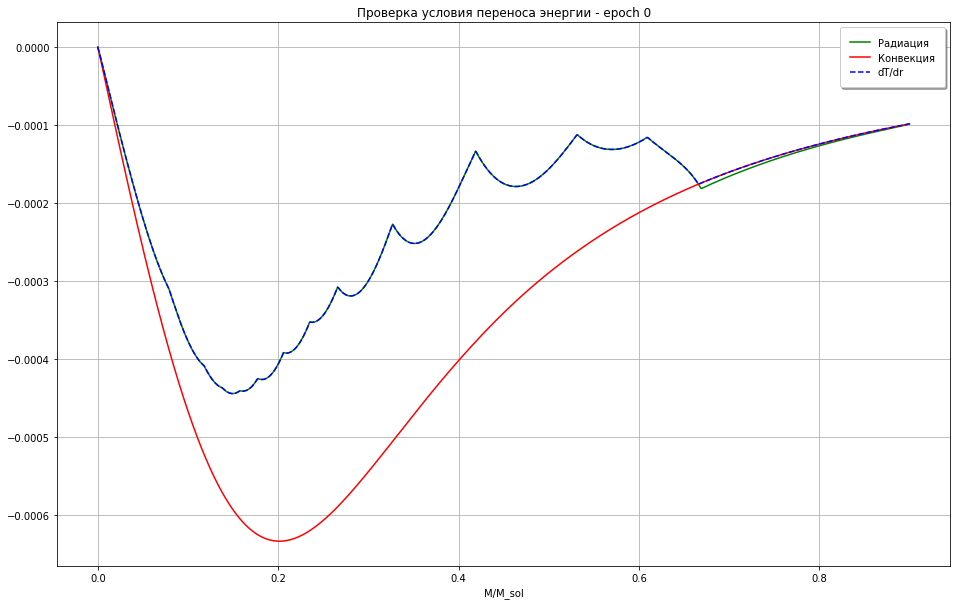

In [122]:

r1 = r[::10]/s.R
b1 = br[::10]
b2 = bc[::10]
db1 = db[::10]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, b1, color='green', label='Радиация')
plt.plot(r1, b2, color='red', label='Конвекция')
plt.plot(r1, db1, '--', color='blue', label='dT/dr')
# plt.xlim(0,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Проверка условия переноса энергии - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [123]:
sa = 0
sb = 0
for i in range(1, dimM-1):
    sa += pow((da[i] - a[i])/a[i], 2)
    sb += pow((db[i] - b[i])/b[i], 2)
sa, sb    

(0.277172384250271, 0.27260092353565024)

In [117]:
dimM

14000

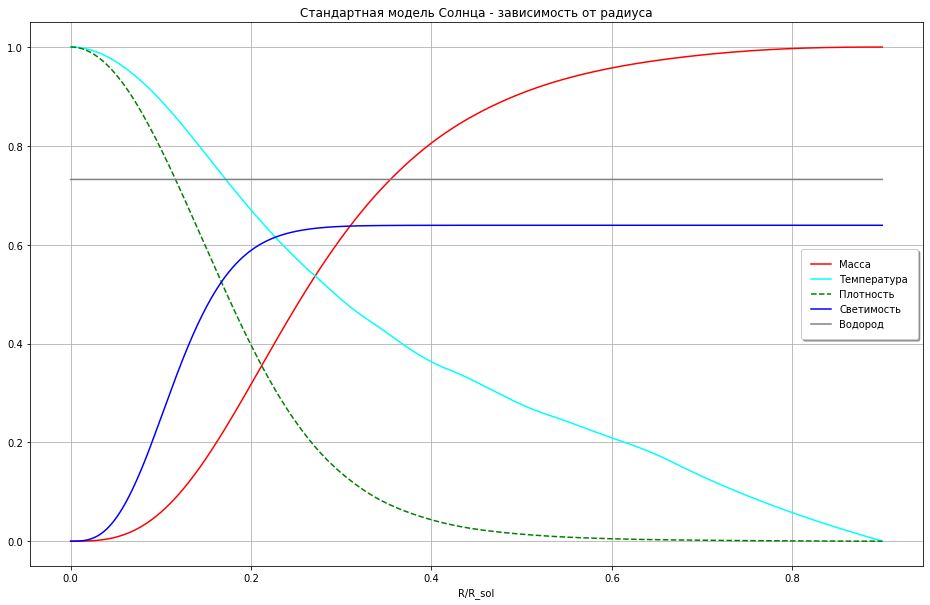

In [118]:
r1 = r/s.R
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, m/s.M, color='red', label='Масса')
plt.plot(r1, t/t[0], color='cyan', label='Температура')
# plt.plot(r1[1:], d1[1:]/d[0], color='green', label='Плотность')
plt.plot(r1, d/d[0], '--', color='green', label='Плотность')
plt.plot(r1, l/s.L, color='blue', label='Светимость')
plt.plot(r1, x, color='gray', label='Водород')
# plt.plot(r1, p1/p1[0], color='black', marker='.', label='Давление')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от радиуса')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

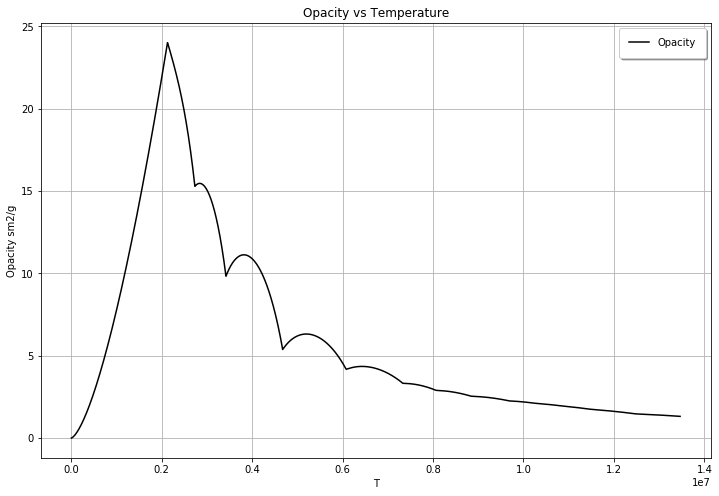

In [119]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.plot(t, k, color='black', label='Opacity')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
#plt.xlim(6, 7.25)
#plt.ylim(0, 20)
plt.xlabel('T')
plt.ylabel('Opacity sm2/g')
plt.title('Opacity vs Temperature')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);